<a href="https://colab.research.google.com/github/matinmazid/York_ML_certificate/blob/master/Consumer_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
  print("GPU is available")
else:
  print("GPU is NOT available")

GPU is NOT available


In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/complaints.csv.zip',compression="zip")
# df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/consumer_complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2021-08-02,"Credit reporting, credit repair services, or o...",Other personal consumer report,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"Early Warning Services, LLC",GA,30326,NaN,Consent not provided,Web,2021-08-02,Closed with explanation,Yes,NaN,4595929
1,2021-08-02,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,Original Debt is from XXXX in the amount of {$...,NaN,"Revco Management, LLC",VA,23513,NaN,Consent provided,Web,2021-08-03,Closed with non-monetary relief,Yes,NaN,4596680
2,2014-05-16,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"EQUIFAX, INC.",FL,33283,NaN,NaN,Postal mail,2014-06-10,Closed with non-monetary relief,Yes,Yes,856572
3,2017-03-04,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,FRESNO CREDIT BUREAU,CA,92117,NaN,Consent not provided,Web,2017-03-08,Closed with explanation,Yes,No,2371613
4,2024-11-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"CBC Companies, Inc.",MS,39736,NaN,NaN,Web,2024-11-23,Closed with explanation,Yes,NaN,10904409


In [9]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [10]:
df.count()

,0
Date received,2301581
Product,2301581
Sub-product,2249375
Issue,2301581
Sub-issue,2064631
Consumer complaint narrative,2301581
Company public response,1228000
Company,2301581
State,2293334
ZIP code,2301581


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301581 entries, 1 to 6878530
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 333.6+ MB

In [12]:
df=df.sample(frac=0.2, replace=True, random_state=14);

In [13]:
df.count()

,0
Date received,460316
Product,460316
Sub-product,449870
Issue,460316
Sub-issue,413159
Consumer complaint narrative,460316
Company public response,245758
Company,460316
State,458715
ZIP code,460316


In [14]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [15]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [16]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [17]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [18]:
df.head()

,Product,Consumer_complaint_narrative,category_id
3498806,Credit reporting or other personal consumer re...,I filed a dispute for incorrect information on...,0
300520,Mortgage,"My name is XXXX XXXX, I live in XXXX XXXX, SD ...",1
4190828,Credit card or prepaid card,Someone applied for an American Express Card u...,2
1259041,Credit reporting or other personal consumer re...,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...,0
2888658,Mortgage,NationStar Mortgage acting as the Servicer of ...,1


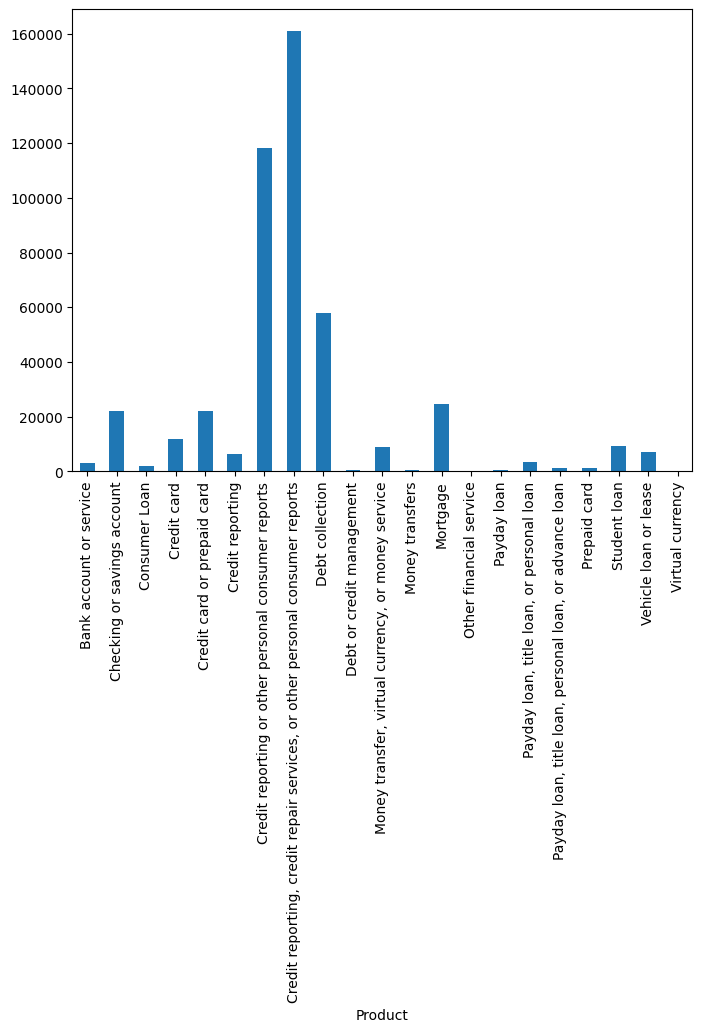

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(460316, 616689)

In [22]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . citigold
       . scottrade
  . Most correlated bigrams:
       . scottrade bank
       . citigold checking
# 'Checking or savings account':
  . Most correlated unigrams:
       . funds
       . bank
  . Most correlated bigrams:
       . savings account
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . simple car
       . delbert services
# 'Credit card':
  . Most correlated unigrams:
       . overdue
       . card
  . Most correlated bigrams:
       . bureau start
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . 2016
       . equifax
  . Most correlated bigrams:
       . tax lien
       . disputed resolve
# 'Credit reporting or ot

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [25]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [26]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id


In [27]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
424,Credit reporting,I am disputing the inaccurate information the ...,5


the above looks right.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:

  model_name = model.__class__.__name__
  print(f" model {model_name} ")
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    print( f" fold_idx: {fold_idx}")
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

 model RandomForestClassifier 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


 fold_idx: 0
 fold_idx: 1
 fold_idx: 2
 fold_idx: 3
 fold_idx: 4
 model LinearSVC 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


 fold_idx: 0
 fold_idx: 1
 fold_idx: 2
 fold_idx: 3
 fold_idx: 4
 model MultinomialNB 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


 fold_idx: 0
 fold_idx: 1
 fold_idx: 2
 fold_idx: 3
 fold_idx: 4
 model LogisticRegression 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

 fold_idx: 0
 fold_idx: 1
 fold_idx: 2
 fold_idx: 3
 fold_idx: 4


<ipython-input-29-72f014537037>:4: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


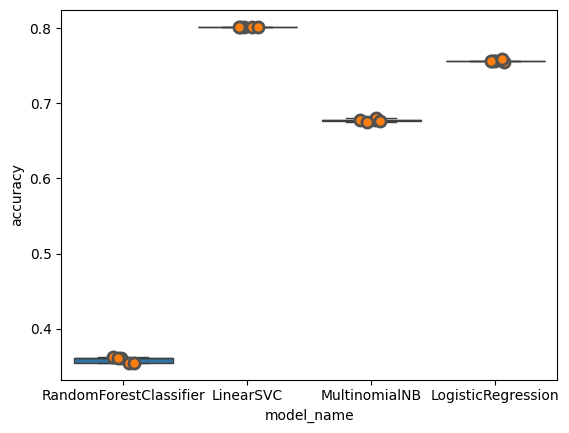

In [29]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [30]:
cv_df.groupby('model_name').accuracy.mean()

,accuracy
model_name,
LinearSVC,0.801345
LogisticRegression,0.756978
MultinomialNB,0.677491
RandomForestClassifier,0.358793


Above we see that Linear SV gives us the most accurate classification, but we should compare this to a null classifier to see how accurate it really is. Further an accuracy rate of 80% means we are wrong 20% of the time, which is really really significant, if you consider the large population size.

In [31]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

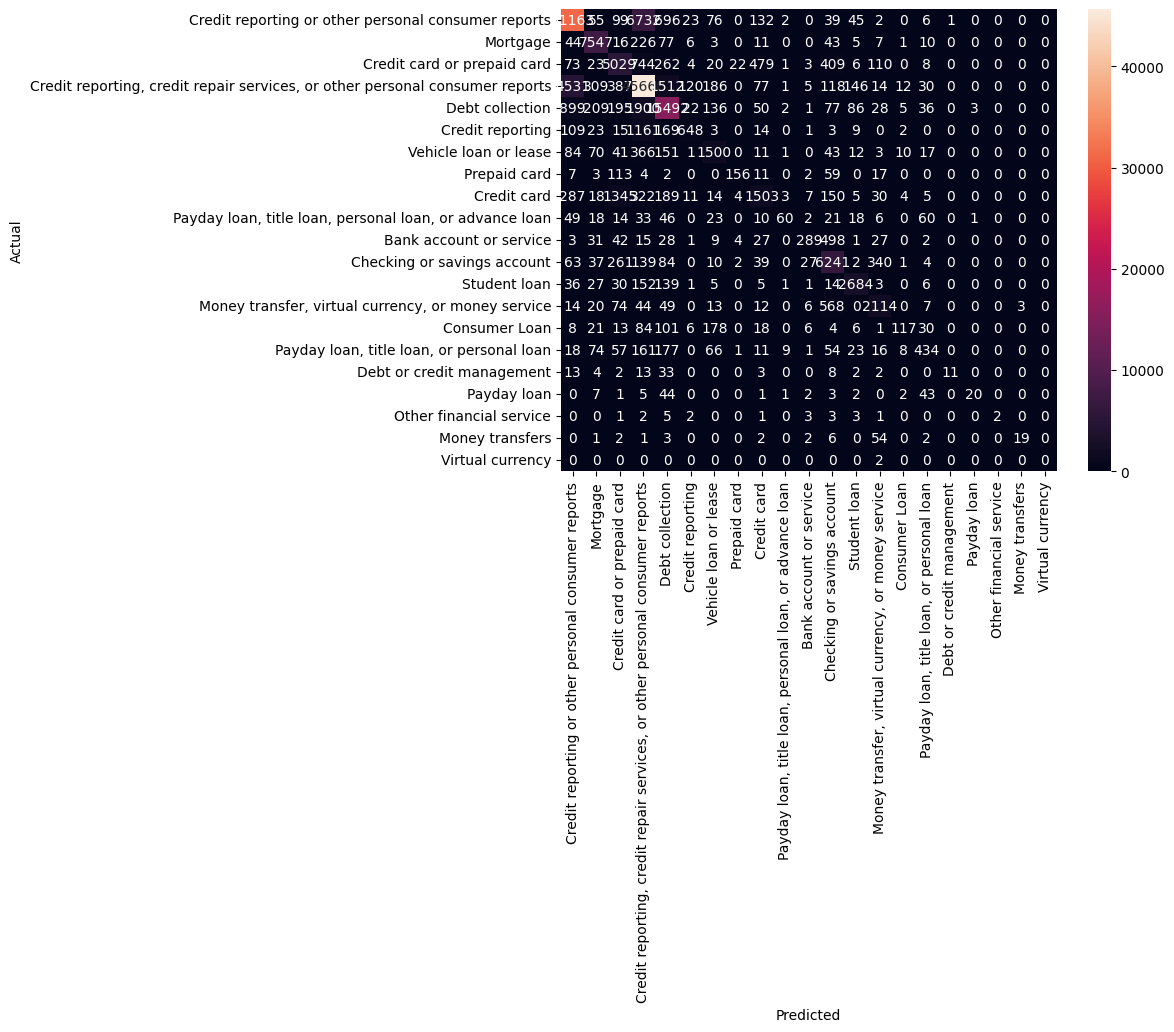

In [32]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We see that linear support vector classification had problems
telling the difference between Credit Reporting, mortgages, credit card, credit repair

In looking at these confusion matric and the name of the category, its possible credit repair, credit reporting
should be lumped together. Its likely these conversations use very similiar verbiage.

If we need to differentiate then we'd have to add more features

In [33]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Mortgage' predicted as 'Credit reporting or other personal consumer reports' : 44 examples.


,Product,Consumer_complaint_narrative
5380996,Mortgage,In my divorce it states that my ex husband is ...
1941429,Mortgage,I am a hardworking individual has been diligen...
2079072,Mortgage,"On XX/XX/2024 XXXX and XXXX, I placed two call..."
2542783,Mortgage,I am no longer a customer of Village Capital a...
2542783,Mortgage,I am no longer a customer of Village Capital a...
6685236,Mortgage,I have made 4 Principal only payments in the l...
688240,Mortgage,I am filing a complaint against Mr. Cooper reg...
1625123,Mortgage,I had autopay set up with my Citizens Bank mor...
5727586,Mortgage,Payment mailing address is listed incorrectly ...
5333794,Mortgage,My mortgage has been paid in full but it's sti...



'Credit card or prepaid card' predicted as 'Credit reporting or other personal consumer reports' : 73 examples.


,Product,Consumer_complaint_narrative
3292724,Credit card or prepaid card,"I applied for an account and was denied, pursu..."
5729674,Credit card or prepaid card,XXXX and XXXX closed my account without notify...
2870557,Credit card or prepaid card,Bank of Americas privacy notices appear to be ...
2870557,Credit card or prepaid card,Bank of Americas privacy notices appear to be ...
2363171,Credit card or prepaid card,"I RECENTLY PULLED MY CREDIT REPORT FROM XXXX, ..."
...,...,...
43090,Credit card or prepaid card,I have an account through XXXX XXXX for a stor...
4904420,Credit card or prepaid card,On XX/XX/XXXX Citi responded stated they will ...
4473173,Credit card or prepaid card,I kindly request that you prioritize this matt...
4927133,Credit card or prepaid card,Kohl 's is reporting inaccurate information to...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting or other personal consumer reports' : 4531 examples.


,Product,Consumer_complaint_narrative
4333109,"Credit reporting, credit repair services, or o...",This is one of several times I've discovered t...
4571704,"Credit reporting, credit repair services, or o...",Please take a look at the attached letters and...
1807878,"Credit reporting, credit repair services, or o...","Previously, I made an investigation about this..."
2128261,"Credit reporting, credit repair services, or o...","According to my research about FCRA 605, Exper..."
2128261,"Credit reporting, credit repair services, or o...","According to my research about FCRA 605, Exper..."
...,...,...
2825016,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
4594020,"Credit reporting, credit repair services, or o...",I began disputing inaccurate information on my...
4594020,"Credit reporting, credit repair services, or o...",I began disputing inaccurate information on my...
6081244,"Credit reporting, credit repair services, or o...",There is an account on my credit report that i...



'Debt collection' predicted as 'Credit reporting or other personal consumer reports' : 899 examples.


,Product,Consumer_complaint_narrative
1640906,Debt collection,I reached out to Rent Recovery Solution by pho...
2894955,Debt collection,"After examining my credit report, I observed i..."
3265109,Debt collection,15 usc 1681a2 I didnt give written permission ...
2739984,Debt collection,"Hello, The alledged detailed account is detail..."
2159928,Debt collection,"Upon reviewing my credit report, I have identi..."
...,...,...
14498,Debt collection,Someone stole my identity and applied to serva...
1163632,Debt collection,PLEASE BLOCKED AND REMOVED I did not initiate ...
1362822,Debt collection,"Dear Debt Collector, I recently received a deb..."
2873595,Debt collection,I understand the significance of eliminating a...



'Credit reporting' predicted as 'Credit reporting or other personal consumer reports' : 109 examples.


,Product,Consumer_complaint_narrative
6478702,Credit reporting,A settlement agreement was made with XXXX ( XX...
319747,Credit reporting,I was trying to get service from XXXX XXXX but...
6649051,Credit reporting,all XXXX cr bu are reporting bankruptcy in 200...
6477588,Credit reporting,I 've been monitoring my credit report and I n...
6646625,Credit reporting,These items do not belong to me and need to be...
...,...,...
6463047,Credit reporting,Hello : I have a school loan that has been def...
304620,Credit reporting,Equifax is reporting an authorized user accoun...
63158,Credit reporting,As of XX/XX/2017 I have noticed an address on ...
360532,Credit reporting,Experian has somehow included the credit repor...



'Vehicle loan or lease' predicted as 'Credit reporting or other personal consumer reports' : 84 examples.


,Product,Consumer_complaint_narrative
1828715,Vehicle loan or lease,On XX/XX/year> I noticed XXXX payments were se...
1730480,Vehicle loan or lease,Credit Accepted is still reporting to my credi...
2239336,Vehicle loan or lease,"Case number XXXX On XX/XX/XXXX, XXXXXXXX XXXX ..."
3998017,Vehicle loan or lease,The company didnt want to negotiate with me to...
3998017,Vehicle loan or lease,The company didnt want to negotiate with me to...
...,...,...
3602149,Vehicle loan or lease,"I XXXX XXXX, coming forward today to have a co..."
2629673,Vehicle loan or lease,Gm financial has been reporting late payments ...
6624182,Vehicle loan or lease,"The vehicle was reposed, but was paid in full ..."
2816365,Vehicle loan or lease,In accordance with the Fair Credit Reporting A...



'Prepaid card' predicted as 'Credit reporting or other personal consumer reports' : 7 examples.


,Product,Consumer_complaint_narrative
1578912,Prepaid card,I had XXXX transactions of fraud on my account...
642113,Prepaid card,XXXX XXXX XXXX are still not working. This is...
2544033,Prepaid card,Back in XXXX I was a severe victim of identity...
2167762,Prepaid card,I was supposed to get a payout from multiple s...
972925,Prepaid card,Card was stolen and reported to Wisely. Disput...
3262419,Prepaid card,"Hi, I opened a XXXX XXXX account that offered ..."
603695,Prepaid card,"On XX/XX/year>, my wallet, containing my drive..."



'Credit card' predicted as 'Credit reporting or other personal consumer reports' : 287 examples.


,Product,Consumer_complaint_narrative
1753094,Credit card,On XX/XX/XXXX I mailed a certified letter to N...
1954281,Credit card,"From the Date of XX/XX/year> to XX/XX/year>, m..."
4041331,Credit card,I submitted proof of no Bankruptcy under my XX...
2839667,Credit card,Reported my payment as late despite the fact t...
2732505,Credit card,I affirm that the inclusion of incorrectly rep...
...,...,...
1679606,Credit card,I applied for US Banks secured credit card whi...
1452732,Credit card,I respectfully ask that you give priority to t...
1195006,Credit card,I affirm that the inclusion of incorrectly rep...
2453684,Credit card,"As a federally protected consumer, I would lik..."



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit reporting or other personal consumer reports' : 49 examples.


,Product,Consumer_complaint_narrative
579700,"Payday loan, title loan, personal loan, or adv...",This loan has been paid off in full and is sho...
1175891,"Payday loan, title loan, personal loan, or adv...",This organization has a hard time telling the ...
1175891,"Payday loan, title loan, personal loan, or adv...",This organization has a hard time telling the ...
3269087,"Payday loan, title loan, personal loan, or adv...",There was an account created for my old phone ...
3518275,"Payday loan, title loan, personal loan, or adv...",One Main Financial didn't give me a proper arb...
1602617,"Payday loan, title loan, personal loan, or adv...","This debt collector engaged in abusive, decept..."
3004814,"Payday loan, title loan, personal loan, or adv...",I opened a loan with Koalafi in XX/XX/year> an...
1306677,"Payday loan, title loan, personal loan, or adv...","On or about XX/XX/2024, I reached out to Marin..."
2094476,"Payday loan, title loan, personal loan, or adv...",When I received notice from XXXX XXXX XXXX tha...
1726798,"Payday loan, title loan, personal loan, or adv...",I am writing to address an issue I encountered...



'Checking or savings account' predicted as 'Credit reporting or other personal consumer reports' : 63 examples.


,Product,Consumer_complaint_narrative
1576005,Checking or savings account,On or around XX/XX/year> I was charged for a o...
2705331,Checking or savings account,"XXXX Lost wallet and ID document, SSN, Driver ..."
966585,Checking or savings account,I responded to a XXXX inquiry within the state...
2116908,Checking or savings account,Charging fee for account that was reported as ...
5538819,Checking or savings account,Re : Cease and Desist From Reporting Informati...
...,...,...
1345984,Checking or savings account,I have not supplied proof under the doctrine o...
3556620,Checking or savings account,I do not have dates and amounts. This has been...
5568117,Checking or savings account,I have submitted several disputes to Early War...
2553139,Checking or savings account,15 USC 6508 I have the right to opt out and th...



'Student loan' predicted as 'Credit reporting or other personal consumer reports' : 36 examples.


,Product,Consumer_complaint_narrative
2745381,Student loan,I am writing to dispute inaccurate information...
3788788,Student loan,Accounts are reporting inaccurately to my cred...
3342668,Student loan,I have Time with this with the forberance or R...
48254,Student loan,I get harassed all the time even when I 'm in ...
2122067,Student loan,In follow up to the last response you are inac...
2099170,Student loan,Current Aidvantage account amount {$3800.00} h...
947749,Student loan,XXXX was ruled to be a predatory lender. They...
1830198,Student loan,I am writing to bring to your attention a deep...
6393823,Student loan,Please delete off of my credit file!
981542,Student loan,I am submitting this follow-up complaint to ad...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting or other personal consumer reports' : 14 examples.


,Product,Consumer_complaint_narrative
1790960,"Money transfer, virtual currency, or money ser...",I bought a product through XXXX XXXX XXXX 2024...
5566643,"Money transfer, virtual currency, or money ser...",CFPD I have been working with 4 different Fian...
2834142,"Money transfer, virtual currency, or money ser...",I hope this message finds you well. My name is...
2044594,"Money transfer, virtual currency, or money ser...","On XX/XX/23, Complainant submitted a formal re..."
1172990,"Money transfer, virtual currency, or money ser...","Dear XXXX, I am writing in response to ( Re : ..."
3052116,"Money transfer, virtual currency, or money ser...",I have a Mercury account ( XXXX XXXX XXXXXXXX ...
947136,"Money transfer, virtual currency, or money ser...",I transferred {$4000.00} to XXXX on XX/XX/year...
5523383,"Money transfer, virtual currency, or money ser...",I FOUND THAT I AM VICTIM OF FRAUD ON XX/XX/XXX...
6249363,"Money transfer, virtual currency, or money ser...",XXXX had a scheduled maintenance window from X...
4737607,"Money transfer, virtual currency, or money ser...",I was a litigant of the XXXX XXXX XXXX XXXX XX...



'Consumer Loan' predicted as 'Credit reporting or other personal consumer reports' : 8 examples.


,Product,Consumer_complaint_narrative
5557173,Consumer Loan,I borrowed {$8900.00} dollars and the being re...
171188,Consumer Loan,i received an e-mail alert telling me that a c...
6384213,Consumer Loan,XX/XX/XXXX I purchased a XXXX chevy 4x4 truck ...
6619413,Consumer Loan,I previously filed a report for Identity Theft...
4360653,Consumer Loan,I have purchased several buy here pay here car...
5630969,Consumer Loan,We are requesting of you to fully investigate ...
6506271,Consumer Loan,After reviewing my XXXX credit report I notice...
6506271,Consumer Loan,After reviewing my XXXX credit report I notice...
299063,Consumer Loan,I had an installment loan with Cash Central wh...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting or other personal consumer reports' : 18 examples.


,Product,Consumer_complaint_narrative
2829919,"Payday loan, title loan, or personal loan",This company on XX/XX/XXXX placed me on a hard...
6596870,"Payday loan, title loan, or personal loan",Got the loan back in XXXX of last year not rea...
3757356,"Payday loan, title loan, or personal loan","Ygrene Financial is a Petitory Lender, it's as..."
4152164,"Payday loan, title loan, or personal loan",I have been a customer at Regions Bank for at ...
5432840,"Payday loan, title loan, or personal loan",I am a victim of identify theft and I have rec...
2092001,"Payday loan, title loan, or personal loan",i went to bank of america to get a loan and i ...
2216840,"Payday loan, title loan, or personal loan",I have a problem with my credit report saying ...
5773289,"Payday loan, title loan, or personal loan",After paying off a loan I ask to make another ...
5609594,"Payday loan, title loan, or personal loan",wellsforgo close my account with out me knowing
4167640,"Payday loan, title loan, or personal loan",XXXX Opened a line of credit with XXXX XXXX XX...



'Debt or credit management' predicted as 'Credit reporting or other personal consumer reports' : 13 examples.


,Product,Consumer_complaint_narrative
1312027,Debt or credit management,In Accordance with the fair credit reporting a...
4507603,Debt or credit management,On today XX/XX/2023 XXXX XXXX XXXX came to my...
2448738,Debt or credit management,"Dear [ Creditor ], I hope this letter finds yo..."
2269530,Debt or credit management,I believe trans union has my information wrong...
3038026,Debt or credit management,an ongoing issue with XXXX Bank and Equifax th...
2161168,Debt or credit management,I was signed up to a membership and charged by...
3583347,Debt or credit management,XX/XX/2024 Subject : CFPB to take off negative...
1041114,Debt or credit management,Ssi is not taxable or can be used to pay a deb...
2931772,Debt or credit management,I canceled my boost Your Score on XX/XX/year> ...
2193592,Debt or credit management,TomoBoost is giving customers a difficult prob...



'Credit reporting or other personal consumer reports' predicted as 'Mortgage' : 55 examples.


,Product,Consumer_complaint_narrative
670027,Credit reporting or other personal consumer re...,"My loan was transferred to Mr. Cooper, which I..."
1111937,Credit reporting or other personal consumer re...,I HAVE TRIED AND TRIED TO RESOLVE THIS XXXX XX...
1214634,Credit reporting or other personal consumer re...,My wife and I were under a forbearance agreeme...
3739918,Credit reporting or other personal consumer re...,Have been working on this issue since XX/XX/20...
758779,Credit reporting or other personal consumer re...,Where is my missing FHA mortgage payment histo...
1404614,Credit reporting or other personal consumer re...,Per the CARES Act initiative the the Dept of T...
1126298,Credit reporting or other personal consumer re...,I applied for a personal loan from PNC Bank. T...
2014571,Credit reporting or other personal consumer re...,En varias ocasiones he solicitado a las agenci...
1592749,Credit reporting or other personal consumer re...,XXXX XXXX XXXX 's mandatory insurance dept 's...
1999407,Credit reporting or other personal consumer re...,My escrow amount changed on XX/XX/2023. \nfor ...



'Credit card or prepaid card' predicted as 'Mortgage' : 23 examples.


,Product,Consumer_complaint_narrative
362339,Credit card or prepaid card,"First, please see complain # XXXX -- XXXX, to ..."
4244360,Credit card or prepaid card,My sister was diagnose with XXXX XXXX XXXX in ...
1999561,Credit card or prepaid card,Around XXXX or XX/XX/XXXX. I was notified that...
2663291,Credit card or prepaid card,I was approved for a Covid 19 deferral of paym...
1803505,Credit card or prepaid card,I have been going through financial hardship f...
3202788,Credit card or prepaid card,Wells Fargo closed my credit card accounts due...
3479275,Credit card or prepaid card,"First, I can not access to Comenitys response ..."
5159911,Credit card or prepaid card,I applied for a mortgage refinance in XX/XX/20...
3522817,Credit card or prepaid card,My line of credit was cancelled. I was told th...
6272743,Credit card or prepaid card,I have notified Wells Fargo in XX/XX/XXXX that...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 309 examples.


,Product,Consumer_complaint_narrative
6640261,"Credit reporting, credit repair services, or o...",I refinanced my rental home and my loan was so...
5725443,"Credit reporting, credit repair services, or o...",PHH Mortgage Services is facilitating fraud an...
5550330,"Credit reporting, credit repair services, or o...",I was recently trying to refinance my mortgage...
6139458,"Credit reporting, credit repair services, or o...",I have a problem with Quicken Loans my mortgag...
4739419,"Credit reporting, credit repair services, or o...",I have been battling with XXXX and subsequentl...
...,...,...
6440401,"Credit reporting, credit repair services, or o...",XX/XX/ XXXX XXXX XXXX bought my mortgage. I wa...
6459357,"Credit reporting, credit repair services, or o...","To Whom It May Concern, RoundPoint stated in t..."
2363543,"Credit reporting, credit repair services, or o...","To whom it may concern, My initial interaction..."
5860804,"Credit reporting, credit repair services, or o...",I regret to say I have not enjoyed being a cus...



'Debt collection' predicted as 'Mortgage' : 209 examples.


,Product,Consumer_complaint_narrative
5741995,Debt collection,"I DONT HAVE OR TAKE OUT A LOAN, I HAVE REQUEST..."
1310635,Debt collection,That's a crucial discovery! If the loan histor...
5664156,Debt collection,XXXX XXXX a loan was taken with XXXX.then went...
2402393,Debt collection,"On XXXX XXXX, I received a note on my front do..."
5706857,Debt collection,"collections calls on an automatic dialer, whic..."
...,...,...
244594,Debt collection,This is the second time that XXXX XXXX XXXX XX...
6494173,Debt collection,XX/XX/XXXX To Whom It May Concern : In XX/XX/X...
837716,Debt collection,SPS Select Portfolio Servicing inc is now the ...
3257593,Debt collection,"Dear Consumer Financial Protection Bureau, I'm..."



'Credit reporting' predicted as 'Mortgage' : 23 examples.


,Product,Consumer_complaint_narrative
6685119,Credit reporting,I have a mortgage account # XXXX XXXX. In XXXX...
5252671,Credit reporting,Several disputes have been sent in regarding m...
5417667,Credit reporting,"XXXX mortgage, XXXX home Equity Line of Credit..."
8658,Credit reporting,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
6699449,Credit reporting,I submitted detailed information asking the co...
50366,Credit reporting,I really need your help with the credit score ...
50366,Credit reporting,I really need your help with the credit score ...
5343812,Credit reporting,In 2010 I was forced to move because of my job...
6451171,Credit reporting,XXXX XXXX XXXX and XXXX XXXX XXXX were the mor...
293050,Credit reporting,I am filing with XXXX XXXX XXXX at the same ti...



'Vehicle loan or lease' predicted as 'Mortgage' : 70 examples.


,Product,Consumer_complaint_narrative
4463695,Vehicle loan or lease,i have been asking the company for years to pu...
1531836,Vehicle loan or lease,It was late at night they told me the bank was...
4600116,Vehicle loan or lease,They wont refinance or lower the payment and i...
6823822,Vehicle loan or lease,I purchased this car in XX/XX/XXXX and at the ...
2758692,Vehicle loan or lease,Flagship Credit of Pennsylvania violates consu...
...,...,...
2835337,Vehicle loan or lease,Auto Lease Account # XXXX During the first wee...
6168045,Vehicle loan or lease,I have a camper loan with state farm bank. Sin...
1376078,Vehicle loan or lease,One they always charge me more for my payment ...
1376078,Vehicle loan or lease,One they always charge me more for my payment ...



'Credit card' predicted as 'Mortgage' : 18 examples.


,Product,Consumer_complaint_narrative
3495695,Credit card,"In XXXX of XXXX, XXXX, an employee of Associat..."
31401,Credit card,"On XXXX XXXX, 2016 I realized I had not made m..."
6454849,Credit card,On XXXX XXXX 2016 I again received marketing e...
5675979,Credit card,hi i just found that i have a judement on my h...
5675979,Credit card,hi i just found that i have a judement on my h...
6676130,Credit card,Discover Card is / has charged off my credit c...
6642413,Credit card,"My payment was due XXXX XXXX, 2016 and althoug..."
1458376,Credit card,This is in reply to complaint # XXXX which was...
128155,Credit card,I have been in a debt management program for X...
5675979,Credit card,hi i just found that i have a judement on my h...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Mortgage' : 18 examples.


,Product,Consumer_complaint_narrative
539813,"Payday loan, title loan, personal loan, or adv...",I called to find out how I can go about it and...
2321682,"Payday loan, title loan, personal loan, or adv...",Sunlight Financial contacted on several occasi...
2165619,"Payday loan, title loan, personal loan, or adv...",Around XX/XX/XXXX I received a text message fr...
481991,"Payday loan, title loan, personal loan, or adv...",When i apply they say XXXX days and we will se...
1568806,"Payday loan, title loan, personal loan, or adv...",I am an Illinois XXXX employee and this compan...
1568806,"Payday loan, title loan, personal loan, or adv...",I am an Illinois XXXX employee and this compan...
2573702,"Payday loan, title loan, personal loan, or adv...",On XX/XX/XXXX XXXX XXXX XXXX XXXX transferred ...
3059569,"Payday loan, title loan, personal loan, or adv...",I wanted to make a partial prepayment today. T...
3868394,"Payday loan, title loan, personal loan, or adv...",I have called the company multiple times over ...
2066647,"Payday loan, title loan, personal loan, or adv...",Relationship start date : XX/XX/XXXX Installme...



'Bank account or service' predicted as 'Mortgage' : 31 examples.


,Product,Consumer_complaint_narrative
6446149,Bank account or service,I paid off my mortgage with Fifth Third Bank. ...
6481714,Bank account or service,Threatened by Bank of America ( BofA ) with fo...
6491227,Bank account or service,Homeowner filed a claim with his insurance com...
6660541,Bank account or service,I received the attached document from Wells Fa...
178000,Bank account or service,I have spoken to 3 employees of Associated Ban...
6665736,Bank account or service,We are attempting to purchase a XXXX property ...
6321647,Bank account or service,"Suntrust Bank has duplicate reports, reflectin..."
6483395,Bank account or service,I 've been trying to get a modification since ...
54000,Bank account or service,"Hello, Re-XXXX my name is XXXX XXXX XXXX, I ha..."
54000,Bank account or service,"Hello, Re-XXXX my name is XXXX XXXX XXXX, I ha..."



'Checking or savings account' predicted as 'Mortgage' : 37 examples.


,Product,Consumer_complaint_narrative
1225958,Checking or savings account,Wells Fargo has provided remediation funds for...
3468440,Checking or savings account,One thing about wells Fargo will charger u fas...
2764889,Checking or savings account,During a mortgage refi application with Wells ...
5822488,Checking or savings account,I had a checking account with Citizen 's accou...
1106175,Checking or savings account,on XX/XX/XXXX I accidentally made a payment to...
1832104,Checking or savings account,I have 5 accounts in Capitol One bank. With on...
5583538,Checking or savings account,The company failed to address the issues noted...
4886249,Checking or savings account,XXXX J.P. Chase Morgan Bank Private Client mor...
5484587,Checking or savings account,I opened a Cadence Bank auto-debit account bec...
6607870,Checking or savings account,Two checks for repairs were issued by insuranc...



'Student loan' predicted as 'Mortgage' : 27 examples.


,Product,Consumer_complaint_narrative
6622014,Student loan,"I paid my loan, but the lender has n't acknowl..."
5594185,Student loan,Chase and XXXX will not provide my full paymen...
6213252,Student loan,My Demand Draft Fraud Complaint Against XXXX X...
3921686,Student loan,I HAVE QUALIFIED FOR THE PSLF FOR THE LAST 18 ...
6189820,Student loan,I received a letter stating I had until XXXX/X...
6479128,Student loan,My loan was transferred to UHEAA from XXXX. Th...
5704499,Student loan,As part of a new home loan a check was sent fr...
45250,Student loan,I have been trying to work with US Bank to get...
6667997,Student loan,I used Citibanks online payment system to make...
4901464,Student loan,The company on more than one occasion refused ...



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 20 examples.


,Product,Consumer_complaint_narrative
6099162,"Money transfer, virtual currency, or money ser...",I paid Guaranteed Rate the balance of my mortg...
6844764,"Money transfer, virtual currency, or money ser...",This company is unethical back in XXXX I was g...
2548614,"Money transfer, virtual currency, or money ser...",I have already reached out to Bank of America ...
3548810,"Money transfer, virtual currency, or money ser...",When finishing filing my tax returns with XXXX...
4483215,"Money transfer, virtual currency, or money ser...",In an effort to close on our home loan today X...
5647354,"Money transfer, virtual currency, or money ser...","I sold my home in XXXX XXXX XXXX, CA to Zillow..."
4825149,"Money transfer, virtual currency, or money ser...",I am filing a complaint today against my mortg...
4628895,"Money transfer, virtual currency, or money ser...",I saw an ad on XXXX for a house for rent conta...
6802460,"Money transfer, virtual currency, or money ser...",Our home in Missouri was flooded on XX/XX/XXXX...
5335794,"Money transfer, virtual currency, or money ser...",Wells Fargo who was ordered to repay customers...



'Consumer Loan' predicted as 'Mortgage' : 21 examples.


,Product,Consumer_complaint_narrative
210874,Consumer Loan,In XX/XX/XXXX my wife and I went to Huntington...
5580973,Consumer Loan,Recently I learned of a problem with our XXXX ...
6605426,Consumer Loan,"I had a car loan with First Premier Financial,..."
5228589,Consumer Loan,We had a Bank of America home equity loan prot...
6682977,Consumer Loan,I paid off my loan in full on XX/XX/2017. I ha...
6496093,Consumer Loan,After Wells Fargo erroneously reported my acco...
6560797,Consumer Loan,I have been a Penfed Credit Union member over ...
218956,Consumer Loan,"I have a consumer loan that was past due, they..."
6668813,Consumer Loan,I was behind on my loan payments but have brou...
4616234,Consumer Loan,The loan officer maintained control of the wir...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 74 examples.


,Product,Consumer_complaint_narrative
5889791,"Payday loan, title loan, or personal loan",In XX/XX/XXXX I received correspodence from Ci...
5841609,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX XXXX in XXXX vs give me a loan ...
5845869,"Payday loan, title loan, or personal loan",I had a loan with a monthly payment of {$86.00...
1619216,"Payday loan, title loan, or personal loan",Wells Fargo ( XXXX XXXX ) Acct. # XXXX On XX/X...
5328161,"Payday loan, title loan, or personal loan",I am writing concerning my attempt to get a co...
...,...,...
5198707,"Payday loan, title loan, or personal loan",In XXXX of XXXX we called our mortgage company...
5721129,"Payday loan, title loan, or personal loan","Dear Sir/Madam : I have enclosed cover letter,..."
2610427,"Payday loan, title loan, or personal loan","This summer in XXXX, N.C. I purchased a new mo..."
5633629,"Payday loan, title loan, or personal loan",SpeedyCash. \nWhen I pay more than the balance...



'Payday loan' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
6466456,Payday loan,I do not want this lender to contact me anymor...
6627928,Payday loan,"I had a loan in place, I called on XXXX/XXXX/2..."
5385026,Payday loan,I rec 'd a loan from dollar quick in XXXX XXXX...
6602946,Payday loan,I have no idea how I could owe this money. \nT...
200038,Payday loan,"on XX/XX/XXXX I signed up for a loan from "" CH..."
4780,Payday loan,I received a letter from Santander Bank ( XXXX...
4524840,Payday loan,they are rip-me off for this loan. \nmy loan a...



'Credit reporting or other personal consumer reports' predicted as 'Credit card or prepaid card' : 99 examples.


,Product,Consumer_complaint_narrative
2613594,Credit reporting or other personal consumer re...,XXXX credit inquiry from Destiny Master Card. ...
1801639,Credit reporting or other personal consumer re...,"I have applied for a Capital One XXXX XXXX, su..."
3521216,Credit reporting or other personal consumer re...,One several occasions late payments were liste...
2859448,Credit reporting or other personal consumer re...,I received a hard inquiry on my credit report ...
2391093,Credit reporting or other personal consumer re...,Someone on the XXXX got my information off- li...
...,...,...
1077501,Credit reporting or other personal consumer re...,"I bank at United States Bank in XXXX XXXX, ore..."
1326948,Credit reporting or other personal consumer re...,This account was open for XXXX XXXX. The balan...
2296186,Credit reporting or other personal consumer re...,I had a business credit card with Chase. Due t...
1229291,Credit reporting or other personal consumer re...,"On or about XX/XX/2019, my XXXX XXXX credit ca..."



'Mortgage' predicted as 'Credit card or prepaid card' : 16 examples.


,Product,Consumer_complaint_narrative
5045324,Mortgage,consumer credit transaction initiated with Ban...
5373104,Mortgage,I notified AmeriHome that I was impacted by CO...
1682000,Mortgage,On XX/XX/XXXX I made an error and sent my mort...
6229108,Mortgage,There is delayed that is being reported on my ...
6229108,Mortgage,There is delayed that is being reported on my ...
5606874,Mortgage,I selected a mortgage provider on Bankrate.com...
152640,Mortgage,capital one violation of contract
6571897,Mortgage,I am current on my payments so far. \nThe prob...
2209998,Mortgage,When I go in to make a payment on XXXX their...
6661646,Mortgage,Goldencreditscore.com and realtystore.com are ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 387 examples.


,Product,Consumer_complaint_narrative
5121070,"Credit reporting, credit repair services, or o...",I had a credit card with Bank of America that ...
6200732,"Credit reporting, credit repair services, or o...",My credit report shows an old XXXX XXXX accoun...
6200732,"Credit reporting, credit repair services, or o...",My credit report shows an old XXXX XXXX accoun...
3577027,"Credit reporting, credit repair services, or o...",I did NOT ask to apply for this card from XXXX...
5958327,"Credit reporting, credit repair services, or o...",I have worked hard on paying my debt with citi...
...,...,...
3163732,"Credit reporting, credit repair services, or o...",I opened a XXXX XXXX Credit Card account inXXX...
4000047,"Credit reporting, credit repair services, or o...",They took my income. They asked me how much cr...
3323640,"Credit reporting, credit repair services, or o...",I got a credit card with Capital One and Ive w...
6241758,"Credit reporting, credit repair services, or o...",I have been working diligently for a number of...



'Debt collection' predicted as 'Credit card or prepaid card' : 195 examples.


,Product,Consumer_complaint_narrative
3551270,Debt collection,Had credit card with HSBC. \nCard service was ...
2768671,Debt collection,"Hi, my name is XXXX XXXX a XXXX XXXX guy. \n\n..."
6225007,Debt collection,Please see letter of communication sent to the...
5017084,Debt collection,I set up for full account payoff effective XX/...
5682713,Debt collection,XX/XX/2020 Wayfair order placed online order #...
...,...,...
469839,Debt collection,XXXX was fraudulently opened and chime was a p...
2794313,Debt collection,This company is part of a debt consolidation &...
2535217,Debt collection,On XX/XX/XXXX I was charged {$71.00} by XXXX a...
152616,Debt collection,I had a XXXX XXXX credit card. It was a secure...



'Credit reporting' predicted as 'Credit card or prepaid card' : 15 examples.


,Product,Consumer_complaint_narrative
240705,Credit reporting,"Hi, I was recently on credit karma reviewing m..."
5339762,Credit reporting,"In XXXX of 2013, I enlisted in the military. P..."
6684769,Credit reporting,1. at this time. home depot is paid in full. i...
6684769,Credit reporting,1. at this time. home depot is paid in full. i...
6651665,Credit reporting,I received communication from equifax giving m...
338389,Credit reporting,I submitted all the forms as required for an e...
6684769,Credit reporting,1. at this time. home depot is paid in full. i...
6684769,Credit reporting,1. at this time. home depot is paid in full. i...
4686362,Credit reporting,Never inquired for this card
6544219,Credit reporting,I applied for a credit card and was denied ( s...



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
4413412,Vehicle loan or lease,I was shocked when I reviewed my credit report...
5309043,Vehicle loan or lease,I see multiple 30 & 60-days late marks which i...
1993430,Vehicle loan or lease,I have had a vehicle loan with Pentagon Federa...
5942805,Vehicle loan or lease,"We financed a XXXX XXXX in XXXX, XXXX for 6 ye..."
5942805,Vehicle loan or lease,"We financed a XXXX XXXX in XXXX, XXXX for 6 ye..."
5880681,Vehicle loan or lease,This particular account situation that is late...
4390672,Vehicle loan or lease,I see multiple 30-60 days late marks which is ...
5711176,Vehicle loan or lease,I see multiple 30-60 days late marks which is ...
2762638,Vehicle loan or lease,I am writing this letter in regard to a recent...
5579811,Vehicle loan or lease,On XX/XX/XXXX I was having an issue paying my ...



'Prepaid card' predicted as 'Credit card or prepaid card' : 113 examples.


,Product,Consumer_complaint_narrative
3506009,Prepaid card,I still can not access via XXXX phone number t...
2455925,Prepaid card,I have been trying to get the rest of my money...
2491974,Prepaid card,Tried activating the Prepaid XXXX gift card by...
2491974,Prepaid card,Tried activating the Prepaid XXXX gift card by...
2603499,Prepaid card,Edd issued XXXX relief which I applied and was...
...,...,...
1634319,Prepaid card,"XX/XX/2023, is the date I put {$50.00} on an A..."
1626246,Prepaid card,I purchased a Serve prepaid card by American E...
1629893,Prepaid card,I purchased a {$200.00} gift card from XXXX XX...
464312,Prepaid card,A real debit card with chip was sent to me in ...



'Credit card' predicted as 'Credit card or prepaid card' : 1345 examples.


,Product,Consumer_complaint_narrative
1510577,Credit card,I have a balance on my credit card with First ...
6664832,Credit card,"In XXXX, a US Bank representative contacted me..."
3649099,Credit card,It is truly absurd to witness late payments re...
1203372,Credit card,I called Synchrony Bank today to try to resolv...
6488358,Credit card,"A former employee, used my personal Home Depot..."
...,...,...
2679471,Credit card,"Amazingly, this is my umpteenth compliant over..."
1923427,Credit card,Citibank closed my Macy 's and Home Depot acco...
169421,Credit card,"On XX/XX/2016, I made a payment via IVR phone ..."
1336423,Credit card,Barclays credit card ending XXXX I took the of...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit card or prepaid card' : 14 examples.


,Product,Consumer_complaint_narrative
758844,"Payday loan, title loan, personal loan, or adv...",I needed a new roof and went through the roofi...
1271854,"Payday loan, title loan, personal loan, or adv...",I received an advance from Albert.com on XX/XX...
3656258,"Payday loan, title loan, personal loan, or adv...",This is a charge off-write off account that is...
3953223,"Payday loan, title loan, personal loan, or adv...",I was charged {$10.00} every month for income ...
2966713,"Payday loan, title loan, personal loan, or adv...","Thursday, XX/XX/XXXX I had an appointment ( ar..."
147748,"Payday loan, title loan, personal loan, or adv...",My wife and I purchased a solar panel system t...
3097915,"Payday loan, title loan, personal loan, or adv...","I spoke with one of the XXXX representative, w..."
1956402,"Payday loan, title loan, personal loan, or adv...",I am writing to file a formal complaint agains...
2346968,"Payday loan, title loan, personal loan, or adv...","Greensky Loan Company discontinued its "" Medic..."
2910651,"Payday loan, title loan, personal loan, or adv...",Payment amounts only applied to interest



'Bank account or service' predicted as 'Credit card or prepaid card' : 42 examples.


,Product,Consumer_complaint_narrative
4783704,Bank account or service,On the morning of the XXXX XXXX I realize ...
6547387,Bank account or service,My netspend debit card got unauthorized transa...
6455412,Bank account or service,PayPal refuses to close my account out or let ...
6465516,Bank account or service,"1. On XXXX/XXXX/16, I called HSBC for a payoff..."
23443,Bank account or service,I applied and shared all my information with t...
88188,Bank account or service,"As a Bank of America customer, I got automatic..."
6685848,Bank account or service,"My corp chain # XXXX, XXXX XXXX, XXXX XXXX XXX..."
55819,Bank account or service,"Hi, I have had a credit card account in good s..."
4944728,Bank account or service,Wells Fargo let an online card take money from...
203521,Bank account or service,I am submitting another complaint about Chase ...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 261 examples.


,Product,Consumer_complaint_narrative
5438465,Checking or savings account,I made a purchase of an item in the amount of ...
5756931,Checking or savings account,I was defrauded by a company called XXXX XXXX ...
1635512,Checking or savings account,Date restricted : XX/XX/XXXX Been a member sin...
5427661,Checking or savings account,In XXXX of 2018 I called my bank requesting a ...
5100328,Checking or savings account,In XXXX of XXXX I received an overdrawn statem...
...,...,...
4164092,Checking or savings account,Keep over drafting and double paying
4663976,Checking or savings account,Wellsfargo withdrew my kids income tax return ...
1070662,Checking or savings account,"On XX/XX/XXXX, I submitted a dispute with Navy..."
4307510,Checking or savings account,Us bank closed my account then reopened to ste...



'Student loan' predicted as 'Credit card or prepaid card' : 30 examples.


,Product,Consumer_complaint_narrative
3970197,Student loan,Re-focusing on past statements PHEAA has provi...
5079954,Student loan,This particular account situation that is late...
4425256,Student loan,MY ACCOUNT IS PAID IN FULL! My account will ge...
4888802,Student loan,I see multiple120 days late marks which is a c...
2613007,Student loan,Problem XXXX : On XX/XX/23 I requested Moehla ...
6617937,Student loan,I was on a repaying option until XXXX 2017. I ...
4697947,Student loan,This particular account situation that is late...
6224633,Student loan,My problem is simple. I 've started out with a...
5846104,Student loan,I have called multiple times from XX/XX/2021 t...
5671124,Student loan,I have been out of work for months now and Im ...



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 74 examples.


,Product,Consumer_complaint_narrative
5711050,"Money transfer, virtual currency, or money ser...",I used the bill payer service for a US Bank Re...
5436238,"Money transfer, virtual currency, or money ser...",XX/XX/2022 I went to XXXX and did get release...
1583345,"Money transfer, virtual currency, or money ser...",I have used the Capital One shopping rewards p...
1106165,"Money transfer, virtual currency, or money ser...",I made a transfer from my card to my account j...
6242119,"Money transfer, virtual currency, or money ser...",I purchased a vacation from a telemarketer. Up...
...,...,...
1531537,"Money transfer, virtual currency, or money ser...",I use Zip ( Quadpay ) for online shopping due ...
3421832,"Money transfer, virtual currency, or money ser...",XX/XX/XXXX Netspend sent a charge back from an...
1773059,"Money transfer, virtual currency, or money ser...",XXXX Texas Police Report REPORT NUMBER : XXXX ...
1258092,"Money transfer, virtual currency, or money ser...",On XX/XX/2023 at XXXX i logged in to my cash a...



'Consumer Loan' predicted as 'Credit card or prepaid card' : 13 examples.


,Product,Consumer_complaint_narrative
29631,Consumer Loan,I applied for a line of credit with Fortiva ba...
6685172,Consumer Loan,I tried returning my rings at Kay jewelrs and ...
4940623,Consumer Loan,This was a revolving account in which I paid W...
6458225,Consumer Loan,I paid off my daughter 's car loan. The compan...
157655,Consumer Loan,I have been a Wells Fargo customer since 1999 ...
24179,Consumer Loan,"At the end of XXXX, 2016 I purchased a XXXX an..."
6507733,Consumer Loan,"On Sunday XXXX XXXX, 2016 I applied for the Ho..."
5493946,Consumer Loan,We never applied for credit at Pay Pal Credit!...
6445302,Consumer Loan,I requested an increase in the credit limit fo...
6519100,Consumer Loan,Opened a line of credit with Fortiva Servicing...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 57 examples.


,Product,Consumer_complaint_narrative
4203770,"Payday loan, title loan, or personal loan",Klarna offers a Financial product called one t...
2673810,"Payday loan, title loan, or personal loan",Personal Line approved for $ XXXX. After takin...
5004404,"Payday loan, title loan, or personal loan",XX/XX/2020 XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
4897751,"Payday loan, title loan, or personal loan",the lender charges a late fee of XXXX dollars ...
5851449,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I submitted a Payment for the fi...
6625954,"Payday loan, title loan, or personal loan",I took out a loan with XXXX XXXX to purchase f...
5271563,"Payday loan, title loan, or personal loan",I was laid off in XXXX and was having issues m...
11723,"Payday loan, title loan, or personal loan","On XX/XX/XXXX, I purchased a XXXX XXXX from XX..."
3921434,"Payday loan, title loan, or personal loan","Original Complaint # XXXX : In XX/XX/XXXX, I s..."
3921434,"Payday loan, title loan, or personal loan","Original Complaint # XXXX : In XX/XX/XXXX, I s..."



'Credit reporting or other personal consumer reports' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 6732 examples.


,Product,Consumer_complaint_narrative
2511300,Credit reporting or other personal consumer re...,From XX/XX/2022 to XX/XX/2022 there have been ...
1668838,Credit reporting or other personal consumer re...,I am a victim of identity theft. The informati...
3464311,Credit reporting or other personal consumer re...,I have contacted Credit Bureaus on numerous oc...
2774389,Credit reporting or other personal consumer re...,I am submitting this complaint to get this mat...
900014,Credit reporting or other personal consumer re...,These companies are selling my personal inform...
...,...,...
1550749,Credit reporting or other personal consumer re...,My information was involved in the XXXX data b...
1816553,Credit reporting or other personal consumer re...,15 USC 1681e ( b ) According to the IRS cancel...
4059069,Credit reporting or other personal consumer re...,Someone ran my credit for a auto loan with all...
1073411,Credit reporting or other personal consumer re...,Delete all accounts



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 226 examples.


,Product,Consumer_complaint_narrative
5897554,Mortgage,XX/XX/XXXX lost my account after my account wa...
6016088,Mortgage,I lost my job two years ago and took advantage...
6447836,Mortgage,I have a mortgage with fifth third. I have nev...
5746979,Mortgage,I was checking credit burial and seen that wel...
4201933,Mortgage,I called US Bank around the XXXX of XX/XX/2020...
...,...,...
4006230,Mortgage,"Factual Data, from XXXX Georgia pull my credit..."
4969975,Mortgage,On XX/XX/XXXX. 2022 - I would like to file a c...
4696296,Mortgage,"XXXX XXXX XXXX and NOVAD Consulting, for mont..."
5654011,Mortgage,Wells Fargo Home Mortgage advertised mortgage ...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 744 examples.


,Product,Consumer_complaint_narrative
9461,Credit card or prepaid card,I reported to JCPenney/XXXX XXXX that I had fr...
6392677,Credit card or prepaid card,Theyre not allowing me to connect a third part...
2240376,Credit card or prepaid card,I received alert on XX/XX/2023 that there was ...
5169608,Credit card or prepaid card,I opened a charge account with XXXX XXXX XXXX ...
6394644,Credit card or prepaid card,When closing my Victoria Secret Credit Card ( ...
...,...,...
6366261,Credit card or prepaid card,I applied for a credit card with PennFed Credi...
5034362,Credit card or prepaid card,I took advantage of a citi flex loan offer fro...
3660623,Credit card or prepaid card,"My wife and I went to purchase furniture, when..."
3245445,Credit card or prepaid card,See the attached documents. I want the bureau ...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1900 examples.


,Product,Consumer_complaint_narrative
253572,Debt collection,"I have paid this balance about 6 month ago, bu..."
3723029,Debt collection,I am writing regards to the frivolous inquires...
5342213,Debt collection,On XX/XX/XXXX I filed complaint number XXXX wi...
4177435,Debt collection,Made several attempts to resolve this issue bu...
1222276,Debt collection,Remove the charge offs from my credit report.
...,...,...
84902,Debt collection,Co sign for auto Loan was not aware loan not a...
84902,Debt collection,Co sign for auto Loan was not aware loan not a...
6690409,Debt collection,Notice to Cease and Desist To Whom it May Conc...
4666803,Debt collection,The consumer is here to dispute any alleged cl...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1161 examples.


,Product,Consumer_complaint_narrative
6507,Credit reporting,I have written Trans Union and asked them to r...
360308,Credit reporting,Experian is reporting a Charge-off on account ...
6548097,Credit reporting,I submitted a dispute to all three credit repo...
6670045,Credit reporting,There is a collection account appearing on my ...
89004,Credit reporting,I provided a case dismissed report for this XX...
...,...,...
6667158,Credit reporting,1.My credit report has a record of many accoun...
14327,Credit reporting,I had checked XXXX XXXX around XXXX XXXX as I ...
52948,Credit reporting,I contacted Transunion on XXXX/XXXX/16 and req...
52948,Credit reporting,I contacted Transunion on XXXX/XXXX/16 and req...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 366 examples.


,Product,Consumer_complaint_narrative
4372937,Vehicle loan or lease,ALLY FINCL {$21000.00} Requesting to remove th...
6379688,Vehicle loan or lease,I recently filed and have been discharged from...
6266223,Vehicle loan or lease,"I traded XXXX my car, loan # XXXX, in XX/XX/20..."
1993678,Vehicle loan or lease,The bank is reporting one late payment ( XXXX ...
3551059,Vehicle loan or lease,I received a letter from Credit Appentance sta...
...,...,...
6598938,Vehicle loan or lease,I have a car loan for my XXXX XXXX XXXX that I...
6598938,Vehicle loan or lease,I have a car loan for my XXXX XXXX XXXX that I...
2687709,Vehicle loan or lease,"I am unsure if this is the right "" reasoning '..."
6132309,Vehicle loan or lease,Please see my original complaint here # XXXX. ...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 322 examples.


,Product,Consumer_complaint_narrative
5518107,Credit card,Capital One violated the FCRA 623 ( a ) Duty t...
3760687,Credit card,See the attached documents. I want the bureau ...
62034,Credit card,my company is apart of my bankruptcy case who ...
3288828,Credit card,In accordance with the Fair Credit Reporting a...
1452139,Credit card,As appear on experian and credit karma XXXX No...
...,...,...
1931443,Credit card,I am writing to delete the following informati...
1931443,Credit card,I am writing to delete the following informati...
172251,Credit card,"The Home Depot failed to remove my name, as pr..."
235651,Credit card,"Six years ago, I opened an HSBC account for my..."



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 33 examples.


,Product,Consumer_complaint_narrative
1842033,"Payday loan, title loan, personal loan, or adv...",I put in a complaint and the response of there...
1855323,"Payday loan, title loan, personal loan, or adv...",I applied for a account with the store called ...
2086635,"Payday loan, title loan, personal loan, or adv...",Unauthorized inquiries on on my report notice ...
1504561,"Payday loan, title loan, personal loan, or adv...",I have had a line of Credit with credit fresh ...
1336778,"Payday loan, title loan, personal loan, or adv...",Lost job and couldn't pay loan. The loan was {...
1708500,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX Consumer Finance Protection Bureau ...
1708500,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX Consumer Finance Protection Bureau ...
2362653,"Payday loan, title loan, personal loan, or adv...",In 2020 I reached out to Navy Federal in regar...
3463222,"Payday loan, title loan, personal loan, or adv...",I accepted a loan from XXXX XXXX for {$850.00}...
1166981,"Payday loan, title loan, personal loan, or adv...",This is not my account. I have asked the credi...



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


,Product,Consumer_complaint_narrative
320344,Bank account or service,I just received an alert from XXXX. It says I ...
6677429,Bank account or service,I have reported to the financial institution f...
6677429,Bank account or service,I have reported to the financial institution f...
84089,Bank account or service,I tried to open checking account with XXXX and...
208655,Bank account or service,I had called to change an address of a nonprof...
6624392,Bank account or service,I am unable to access the website XXXX from XX...
6481516,Bank account or service,"As my letters indicate, I declared bankruptcy ..."
6449016,Bank account or service,I wanted to update my last name after my divor...
6677429,Bank account or service,I have reported to the financial institution f...
6677429,Bank account or service,I have reported to the financial institution f...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 139 examples.


,Product,Consumer_complaint_narrative
6235723,Checking or savings account,Trying to use XXXX to invest once baks accoun...
4959273,Checking or savings account,I fil a dispute later no respon
4338047,Checking or savings account,I have been attempting to get resolution for C...
5169982,Checking or savings account,Please add this addendum to my current account...
5169982,Checking or savings account,Please add this addendum to my current account...
...,...,...
6600027,Checking or savings account,My name is XXXX XXXX and I 'm a victim of Iden...
6600027,Checking or savings account,My name is XXXX XXXX and I 'm a victim of Iden...
2183802,Checking or savings account,CitiBank NA repeatedly sent me a Member Advant...
6259087,Checking or savings account,On thursday or wenesday an unauthorized websit...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 152 examples.


,Product,Consumer_complaint_narrative
6472312,Student loan,I was treated unfairly with my students loans ...
5764207,Student loan,Account No. XXXX XXXX dba XXXX XXXX XXXX ( XXX...
3787155,Student loan,dept of telnet is on my credit report multiple...
5859882,Student loan,"I was affected by Hurricane Harvey, XXXX XXXX ..."
6571450,Student loan,"Hello, I got an email about 2 years ago from X..."
...,...,...
6315838,Student loan,I signed up for autopay to pay student loans b...
89547,Student loan,XXXX has repeatedly failed to process informat...
1907567,Student loan,I have numerous requested over and over same p...
2328466,Student loan,I have tried for several months to have late p...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 44 examples.


,Product,Consumer_complaint_narrative
2401491,"Money transfer, virtual currency, or money ser...",I have mailed XXXX municipal bonds that has be...
6845220,"Money transfer, virtual currency, or money ser...","Currently, I have something on my credit that ..."
6232376,"Money transfer, virtual currency, or money ser...",I am trying to connect my personal banking inf...
1977346,"Money transfer, virtual currency, or money ser...",My account was compromised in XXXX of XXXX an...
1977346,"Money transfer, virtual currency, or money ser...",My account was compromised in XXXX of XXXX an...
6386699,"Money transfer, virtual currency, or money ser...",XX/XX/18 States that y'all have blocked me fro...
3335887,"Money transfer, virtual currency, or money ser...",I paid someone to complete a work of art and t...
6219482,"Money transfer, virtual currency, or money ser...","Hello CFPB, XXXX XX/XX/2020, I authorized Plas..."
6478803,"Money transfer, virtual currency, or money ser...",I purchased a recipes and the seller never sen...
6478803,"Money transfer, virtual currency, or money ser...",I purchased a recipes and the seller never sen...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 84 examples.


,Product,Consumer_complaint_narrative
57722,Consumer Loan,I made arrangements for my vehicle payment to ...
6456585,Consumer Loan,I filed bankruptcy XX/XX/XXXX against central ...
6477177,Consumer Loan,I settled a charge off account for partial pay...
6482908,Consumer Loan,BACKGROUND INFORMATION : I took over a 3-year ...
5121943,Consumer Loan,Chase removed my autopay 14 months after I set...
...,...,...
321188,Consumer Loan,"I have a loaned of {$3000.00} on XXXX 2014, My..."
321188,Consumer Loan,"I have a loaned of {$3000.00} on XXXX 2014, My..."
6682697,Consumer Loan,Chase auto finance has repeatedly refused to r...
6437333,Consumer Loan,If you are thinking about financing a vehicle....



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 161 examples.


,Product,Consumer_complaint_narrative
4105854,"Payday loan, title loan, or personal loan",The reason I am writing is because I have been...
2522357,"Payday loan, title loan, or personal loan",There is a mistake with my account because I h...
6107118,"Payday loan, title loan, or personal loan",XXXX sold this loan to First Associates. First...
5132892,"Payday loan, title loan, or personal loan",I run my credit to purchase a bike a month ago...
2959622,"Payday loan, title loan, or personal loan",My information was used without my permission ...
...,...,...
5090332,"Payday loan, title loan, or personal loan",On XX/XX/2019. I received a call from Springle...
2090278,"Payday loan, title loan, or personal loan",Issue is with making payments. Company will no...
4812660,"Payday loan, title loan, or personal loan",My loan was sold to SST due to the company by ...
6019743,"Payday loan, title loan, or personal loan",I am a victim of identity theft. The informati...



'Debt or credit management' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 13 examples.


,Product,Consumer_complaint_narrative
1321968,Debt or credit management,I was told that my debt got canceled due to th...
1493363,Debt or credit management,In 2021 I had 3 negatives as of today I have d...
3120052,Debt or credit management,I sent letters to company about the 2rd party ...
454072,Debt or credit management,I have several numbers for Experian. I used to...
1920091,Debt or credit management,I would just like you to fully verify that the...
1387291,Debt or credit management,"XXXX. XXXX, XXXX XXXX XXXX XXXX XXXXXXXX, XXXX..."
3417215,Debt or credit management,Tomoboost VIP Journey subscription service pro...
3238616,Debt or credit management,Lost job was not able to make payments. Family...
2083516,Debt or credit management,I was a victim of Lexington law they were supp...
840758,Debt or credit management,I have contacted all credit bureaus XXXX XXXX ...



'Credit reporting or other personal consumer reports' predicted as 'Debt collection' : 696 examples.


,Product,Consumer_complaint_narrative
3591369,Credit reporting or other personal consumer re...,On XX/XX/2023 a new collection account was ope...
1776518,Credit reporting or other personal consumer re...,I've tried constantly to dispute these account...
2778959,Credit reporting or other personal consumer re...,"Specifically, 15 USC 6802 defines a "" charge-o..."
2159980,Credit reporting or other personal consumer re...,Request for Removal of Collection Accounts due...
3138922,Credit reporting or other personal consumer re...,"To Whom It May Concern, I am writing to disput..."
...,...,...
1168607,Credit reporting or other personal consumer re...,"Upon reviewing my credit report, I observed in..."
2985575,Credit reporting or other personal consumer re...,I believe that the compliance with FCRA 604B n...
1970260,Credit reporting or other personal consumer re...,Subject : Formal Notice of Violations and Requ...
2382708,Credit reporting or other personal consumer re...,I am writing to bring to your attention a seri...



'Mortgage' predicted as 'Debt collection' : 77 examples.


,Product,Consumer_complaint_narrative
6421241,Mortgage,XX/XX/XXXX Debt Collector : SELECT PORTFOLIO S...
3386993,Mortgage,"On XX/XX/XXXX, we sent all information to comp..."
3386993,Mortgage,"On XX/XX/XXXX, we sent all information to comp..."
4007483,Mortgage,My loan is being serviced by Seterus Inc. and ...
6377516,Mortgage,"I am 30 days behind, but I have but I have bee..."
...,...,...
6498309,Mortgage,Although the company received a federal wire f...
283823,Mortgage,My landlord was recently foreclosed on and we ...
262518,Mortgage,A letter was sent via certified mail to Frankl...
6389258,Mortgage,In XXXX I had made a payment in accident of {$...



'Credit card or prepaid card' predicted as 'Debt collection' : 262 examples.


,Product,Consumer_complaint_narrative
3629313,Credit card or prepaid card,ON XX/XX/XXXX I CONTACTED DISCOVER TO REPORT F...
4289863,Credit card or prepaid card,I purchase a home warranty from XXXX XXXX XXXX...
6341055,Credit card or prepaid card,When attempting to make a payment due XX/XX/20...
3826733,Credit card or prepaid card,Had a XXXX person living with me who I had kn...
6153086,Credit card or prepaid card,I received my bill on XX/XX/XXXX. I went to pa...
...,...,...
4516462,Credit card or prepaid card,I received a letter today dated XXXX from TDD ...
1069296,Credit card or prepaid card,I had a meeting today with my banker to obtain...
1069296,Credit card or prepaid card,I had a meeting today with my banker to obtain...
2043054,Credit card or prepaid card,Got a faulty dryer twice from XXXX XXXX. We wa...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 1512 examples.


,Product,Consumer_complaint_narrative
4338223,"Credit reporting, credit repair services, or o...","I, XXXX XXXX, Consumer, dated on XX/XX/2022, a..."
4338223,"Credit reporting, credit repair services, or o...","I, XXXX XXXX, Consumer, dated on XX/XX/2022, a..."
5762242,"Credit reporting, credit repair services, or o...",XXXX is claiming that I owe them {$830.00}. Th...
4843630,"Credit reporting, credit repair services, or o...",I am purchasing my mother in law 's home I hav...
5518254,"Credit reporting, credit repair services, or o...",In early XXXX I moved out of XXXX XXXX XXXX an...
...,...,...
4646677,"Credit reporting, credit repair services, or o...",According to the FCRA you are violating my rig...
6312438,"Credit reporting, credit repair services, or o...",XXXX XXXX has placed information on my credit ...
6651291,"Credit reporting, credit repair services, or o...",I have a collection on my credit report for a ...
5763320,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX has refused to no longer talk t...



'Credit reporting' predicted as 'Debt collection' : 169 examples.


,Product,Consumer_complaint_narrative
145572,Credit reporting,This complaint is in reference to XXXX account...
6318127,Credit reporting,I had an old collections account with XXXX tha...
162568,Credit reporting,XXXX # XXXXTransunion account # XXXXFrom XXXX ...
6876649,Credit reporting,I have been dealing with this issue since XXXX...
6382260,Credit reporting,My credit report shows that I owe XXXX XXXX an...
...,...,...
171038,Credit reporting,There is a report of collection for {$100.00}....
2202349,Credit reporting,FRAUDULENT BILLING FROM COLLECTOR FOR INCOMPET...
2202349,Credit reporting,FRAUDULENT BILLING FROM COLLECTOR FOR INCOMPET...
3567343,Credit reporting,Contacted XXXX regarding a medical collection ...



'Vehicle loan or lease' predicted as 'Debt collection' : 151 examples.


,Product,Consumer_complaint_narrative
5246030,Vehicle loan or lease,"I have transmitted Affidavits, including certi..."
4793546,Vehicle loan or lease,Actually the vehicle loan is for my husband an...
3719989,Vehicle loan or lease,I was going through a hard time in 2016 I move...
5504970,Vehicle loan or lease,So I am working with bridge crest financial to...
3647077,Vehicle loan or lease,"First of all, there is no statue of limitation..."
...,...,...
2510163,Vehicle loan or lease,I explained to the company that I have been la...
12664,Vehicle loan or lease,WESTLAKE contacted me about a payment arrangem...
2646521,Vehicle loan or lease,"I currently have a car an XXXX XXXX XXXX XXXX,..."
5550309,Vehicle loan or lease,i missed 3 payments called to notify the lende...



'Credit card' predicted as 'Debt collection' : 189 examples.


,Product,Consumer_complaint_narrative
6450705,Credit card,I keep getting calls XXXX. There have been 7 c...
6445428,Credit card,I filed for chapter XXXX bankruptcy and had al...
1359608,Credit card,I am writing to formally request the validatio...
2003747,Credit card,I received the response from the CFPB regardin...
4595958,Credit card,I have asked Macys department store to stop ca...
...,...,...
2030498,Credit card,Apparently my ex-husband made a payment on his...
3268963,Credit card,NOTICE OF BILLING ERROR *NOTICE TO AGENT IS NO...
3268963,Credit card,NOTICE OF BILLING ERROR *NOTICE TO AGENT IS NO...
1763604,Credit card,"Unifund LLC, sent numerous letters to two of m..."



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Debt collection' : 46 examples.


,Product,Consumer_complaint_narrative
681069,"Payday loan, title loan, personal loan, or adv...","I would like to review this account, what perc..."
1961699,"Payday loan, title loan, personal loan, or adv...",As of XX/XX/XXXXXXXX XXXX XXXX the company ad...
1346516,"Payday loan, title loan, personal loan, or adv...",I entered a payment arrangement for XXXX XXXX ...
2077965,"Payday loan, title loan, personal loan, or adv...",They repeatedly call me at work on a daily bas...
887309,"Payday loan, title loan, personal loan, or adv...",I tried to change my phone number online and c...
3556946,"Payday loan, title loan, personal loan, or adv...",I ask Opportun service representative XXXX if ...
3178144,"Payday loan, title loan, personal loan, or adv...",This was taken care of. \nOpened XX/XX/17 Paid...
1687569,"Payday loan, title loan, personal loan, or adv...","A solar panel company named "" XXXX XXXX '' wor..."
3225457,"Payday loan, title loan, personal loan, or adv...","XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, in XX..."
1639254,"Payday loan, title loan, personal loan, or adv...",I approached XXXX XXXX ( XXXX XXXX XXXX ) afte...



'Bank account or service' predicted as 'Debt collection' : 28 examples.


,Product,Consumer_complaint_narrative
79220,Bank account or service,I have been contacted by several companies reg...
187551,Bank account or service,Please DO NOT close my complaint # XXXX. Capit...
187551,Bank account or service,Please DO NOT close my complaint # XXXX. Capit...
6517259,Bank account or service,I went to the bank of America on XXXX XXXX XXX...
6560889,Bank account or service,My wife and I were vacationing in XXXX XXXX XX...
1644042,Bank account or service,I went on line to ask for a Bank of America ac...
258570,Bank account or service,I was contacted by an individual who told me h...
6463028,Bank account or service,I sold a phone on eBay. The seller paid via Pa...
6479500,Bank account or service,I had a debt with Synchrony Bank {$570.00} and...
6692476,Bank account or service,"I had a checking, savings and credit line acco..."



'Checking or savings account' predicted as 'Debt collection' : 84 examples.


,Product,Consumer_complaint_narrative
5885209,Checking or savings account,The company i used to work for is no longer in...
5885209,Checking or savings account,The company i used to work for is no longer in...
5885209,Checking or savings account,The company i used to work for is no longer in...
3436981,Checking or savings account,"In late XXXX, I received a bank statement that..."
5885209,Checking or savings account,The company i used to work for is no longer in...
...,...,...
2431227,Checking or savings account,On XX/XX/XXXX I was called by a verified Bank ...
4120702,Checking or savings account,Navy Federal Indicated there was suspected fra...
4563788,Checking or savings account,The bank will not take my outstanding payment ...
6267846,Checking or savings account,My checking account was defrauded out of $ {$9...



'Student loan' predicted as 'Debt collection' : 139 examples.


,Product,Consumer_complaint_narrative
6684814,Student loan,Naviet has on multiple occasions put checks an...
6679164,Student loan,I do have a student loan open with XXXX. I am ...
6216737,Student loan,"I was contacted by the "" XXXX XXXX XXXX '', XX..."
5496334,Student loan,I sent XXXX XXXX This affidavit asking for pro...
2113979,Student loan,I was pressured to sign up for these loans whi...
...,...,...
6706908,Student loan,I just wrote up a XXXX description and it is n...
869203,Student loan,I previously submitted a complaint on XX/XX/XX...
246123,Student loan,I am cosigner on my daughters XXXX loan. My da...
6459209,Student loan,Salle May has been calling XXXX 8 times a day ...



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 49 examples.


,Product,Consumer_complaint_narrative
3824269,"Money transfer, virtual currency, or money ser...",Dear Sir/Madam I live in XXXX NJ . Some frauds...
1975198,"Money transfer, virtual currency, or money ser...",I have paid Helbing Law Group $ XXXX to settle...
5111160,"Money transfer, virtual currency, or money ser...","Today ( XXXX ), around XXXX or XXXX XXXX., I r..."
3717703,"Money transfer, virtual currency, or money ser...",A check was sent to me but to my parents house...
2898722,"Money transfer, virtual currency, or money ser...",Re : file number XXXX ( scott and associates i...
4972216,"Money transfer, virtual currency, or money ser...",I transferred XXXX into my checking account fr...
5011203,"Money transfer, virtual currency, or money ser...",I was in search for an emotional support dog a...
5235360,"Money transfer, virtual currency, or money ser...",In XXXX I paid XXXX XXXX a {$300.00} advance v...
5220939,"Money transfer, virtual currency, or money ser...",Debt Negotiation Services a debt settlement co...
3648482,"Money transfer, virtual currency, or money ser...",XX/XX/23 I used my credit union to make a bill...



'Consumer Loan' predicted as 'Debt collection' : 101 examples.


,Product,Consumer_complaint_narrative
6697622,Consumer Loan,This is actually a dispute complaint to respon...
5405396,Consumer Loan,I had an account since XXXX 2012 with capital ...
6442658,Consumer Loan,"The loan date is back in XXXX , and last acti..."
6466985,Consumer Loan,I just recently got a new job and the loan com...
6468737,Consumer Loan,"This account was paid in full, see attached pa..."
...,...,...
6630395,Consumer Loan,They call up to 38 times a day even after paym...
6538929,Consumer Loan,I have been making payments on my husband 's a...
6428300,Consumer Loan,I am having trouble with financing I received ...
6668983,Consumer Loan,I leased a car from drive time in XXXX of 2014...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 177 examples.


,Product,Consumer_complaint_narrative
3026995,"Payday loan, title loan, or personal loan",I am currently unemployed and experiencing XXX...
5527315,"Payday loan, title loan, or personal loan","Hello CFPB Complaints Team, It was brought to ..."
2695738,"Payday loan, title loan, or personal loan",I did not apply for auto financing for this de...
5051696,"Payday loan, title loan, or personal loan","On XX/XX/2020, I received an email from GE Cap..."
3224566,"Payday loan, title loan, or personal loan",I was under personal circumstances and were co...
...,...,...
6601215,"Payday loan, title loan, or personal loan","Wells Fargo Bank, N.A. Attorney XXXX XXXX XXXX..."
5607997,"Payday loan, title loan, or personal loan",The company keeps calling me once on XXXX XXXX...
5607997,"Payday loan, title loan, or personal loan",The company keeps calling me once on XXXX XXXX...
5115917,"Payday loan, title loan, or personal loan",1.I have never had an account with this compan...



'Debt or credit management' predicted as 'Debt collection' : 33 examples.


,Product,Consumer_complaint_narrative
1416345,Debt or credit management,This is a third-party debt that I do not owe. ...
3698955,Debt or credit management,I am not liable for this debt with XXXX XXXX X...
1531283,Debt or credit management,"Dear Consumer Financial Protection Bureau, My ..."
979818,Debt or credit management,signed up with Level 1 law firm to debt relief...
3036209,Debt or credit management,I had singed up for debt consolidation with Be...
1304079,Debt or credit management,"Initially, I borrowed {$25000.00} from XXXX XX..."
1442308,Debt or credit management,Hi there so I am currently being sued by Ray K...
2377664,Debt or credit management,XX/XX/2024 I have been contacted by a collecti...
992636,Debt or credit management,XXXX XXXX XXXX - I was in the middle of cancel...
2789812,Debt or credit management,I monitor my credit and bills monthly very clo...



'Payday loan' predicted as 'Debt collection' : 44 examples.


,Product,Consumer_complaint_narrative
6438668,Payday loan,Different companies who say they represent the...
5567448,Payday loan,This lender is calling me incessantly from mul...
6661189,Payday loan,XXXX sent me a email telling me i owed a certa...
4588947,Payday loan,On XXXX XXXX received a call from a XXXX XXXX ...
4735505,Payday loan,I obtained my credit report on XXXX/XXXX/2017 ...
4735505,Payday loan,I obtained my credit report on XXXX/XXXX/2017 ...
49311,Payday loan,I checked my credit reports and I notice an ac...
6656749,Payday loan,I was charged {$89.00} over the actual first m...
303586,Payday loan,It appears that Midland Funding ( original len...
63433,Payday loan,"A debt has been sold, original creditor is not..."



'Credit reporting or other personal consumer reports' predicted as 'Credit reporting' : 23 examples.


,Product,Consumer_complaint_narrative
2787974,Credit reporting or other personal consumer re...,I have requested for them to remove this from ...
1732771,Credit reporting or other personal consumer re...,I went to view my credit reports via XXXX and ...
2124673,Credit reporting or other personal consumer re...,"I am making this claim because, my credit repo..."
529122,Credit reporting or other personal consumer re...,I have requested for my name to be corrected. ...
1451898,Credit reporting or other personal consumer re...,Went on annual credit report and requested fre...
1602315,Credit reporting or other personal consumer re...,I have been unable to obtain my weekly credit ...
2659058,Credit reporting or other personal consumer re...,TransUnion staff taking my debt off my credit ...
3269192,Credit reporting or other personal consumer re...,I have been requesting the removal of errors o...
1442682,Credit reporting or other personal consumer re...,My moving truck was stolen My identity and nam...
3100348,Credit reporting or other personal consumer re...,"In 2007, I was given a company payroll check i..."



'Mortgage' predicted as 'Credit reporting' : 6 examples.


,Product,Consumer_complaint_narrative
955018,Mortgage,have called 4 times ( XXXX & XXXX most recent....
955018,Mortgage,have called 4 times ( XXXX & XXXX most recent....
6681517,Mortgage,My mortgage was transferred from XXXX to M and...
309186,Mortgage,I have written to Statebridge Compnay at least...
309186,Mortgage,I have written to Statebridge Compnay at least...
309186,Mortgage,I have written to Statebridge Compnay at least...
309186,Mortgage,I have written to Statebridge Compnay at least...
955018,Mortgage,have called 4 times ( XXXX & XXXX most recent....
955018,Mortgage,have called 4 times ( XXXX & XXXX most recent....
272320,Mortgage,I was part of a XXXX.settlement : Consent Orde...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 120 examples.


,Product,Consumer_complaint_narrative
6274972,"Credit reporting, credit repair services, or o...",I certainly requested my free annual credit re...
4640198,"Credit reporting, credit repair services, or o...",I have never lived in XXXX
6594461,"Credit reporting, credit repair services, or o...",XXXX XXXX 2016 they submitted a hard credit in...
3262352,"Credit reporting, credit repair services, or o...","Consistently, Experian refuses to add timely p..."
5657264,"Credit reporting, credit repair services, or o...",Experian has unblocked fraudulent items on my ...
...,...,...
4838286,"Credit reporting, credit repair services, or o...",I am filing this Complaint because XXXX has ig...
5400248,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I filed a dispute with TransUni..."
6319591,"Credit reporting, credit repair services, or o...","On XXXX XXXX , XXXX , a federal tax lien i..."
6392185,"Credit reporting, credit repair services, or o...",I XXXX XXXX have tried through three separate ...



'Debt collection' predicted as 'Credit reporting' : 22 examples.


,Product,Consumer_complaint_narrative
268981,Debt collection,A collection company XXXX is reporting XXXX ac...
6611197,Debt collection,My vehicle was traded to XXXX XXXX XXXX on XXX...
6342204,Debt collection,Trans Union need removed XXXX XXXX XXXX docke...
6661401,Debt collection,This debt was not discharged in bankruptcy but...
6661401,Debt collection,This debt was not discharged in bankruptcy but...
4316946,Debt collection,I have filed two police reports due to identit...
229585,Debt collection,I was directed by my employer to use my XXXX X...
6476961,Debt collection,i paid on XXXX XXXX 2016 and have letter showi...
6485558,Debt collection,In XXXX I acquired an unsecured loan from Citi...
6510766,Debt collection,The creditor call me XXXX times in a XXXX time...



'Credit card' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
1335875,Credit card,I filed a claim against a charge from a mercha...
6478578,Credit card,I have requested XXXX XXXX to run a credit rep...
6670151,Credit card,"I am a victim of identity theft, and have been..."
6654555,Credit card,A hard pull on my Equifax credit report from b...
6677039,Credit card,I paid off my Synchrony Belk card via a settle...
55619,Credit card,XXXX separate times I have made reservations w...
6662129,Credit card,I am a victim of identity theft from more than...
65940,Credit card,I monitor my credit reports weekly and found t...
169443,Credit card,I 'm a long time highly qualified Wellsfargo c...
249067,Credit card,XXXX Card stolen - charges exceeded {$8700.00}...



'Consumer Loan' predicted as 'Credit reporting' : 6 examples.


,Product,Consumer_complaint_narrative
6444807,Consumer Loan,"While checking my personal credit report, whic..."
5121197,Consumer Loan,A few months ago I recently reviewed my credit...
6691657,Consumer Loan,TD BANK N.A . has continually reported the wro...
6691691,Consumer Loan,I filed Chapter XXXX in 2008 it was discharged...
213445,Consumer Loan,XX/XX/2016 To Whom It May Concern : Please not...
6667336,Consumer Loan,HELLO this company is did a hard click on my c...



'Credit reporting or other personal consumer reports' predicted as 'Vehicle loan or lease' : 76 examples.


,Product,Consumer_complaint_narrative
2869646,Credit reporting or other personal consumer re...,Someone purchased a vehicle through a Credit A...
1177753,Credit reporting or other personal consumer re...,The following companies made unauthorized hard...
3159648,Credit reporting or other personal consumer re...,Didn't send documentation of complete payment ...
3731040,Credit reporting or other personal consumer re...,I contacted GM Financial and arranged an exten...
3069664,Credit reporting or other personal consumer re...,XXXX got returned because the the car was not ...
...,...,...
2445827,Credit reporting or other personal consumer re...,"On XX/XX/XXXX, I purchased a vehicle through X..."
2710603,Credit reporting or other personal consumer re...,Please delete and remove all late payments. Yo...
3833161,Credit reporting or other personal consumer re...,I bought a vehicle from a Nissan dealership an...
3020613,Credit reporting or other personal consumer re...,This auto loan was opened while I was in Bankr...



'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 20 examples.


,Product,Consumer_complaint_narrative
2384859,Credit card or prepaid card,I am sending you this CFPB complaint today to ...
6489793,Credit card or prepaid card,I was shocked when I reviewed my credit report...
4240241,Credit card or prepaid card,"The response to CFPB XXXX : XXXX states "" the ..."
6585701,Credit card or prepaid card,I live in XXXX Florida and live in a county th...
3854533,Credit card or prepaid card,"Fact, The Truth in Lending Act is intended to ..."
5156076,Credit card or prepaid card,I am a victim of Identity theft. Please delete...
4703457,Credit card or prepaid card,"On or about XX/XX/2021, I entered into a consu..."
5124966,Credit card or prepaid card,I had purchased a vehicle from XXXX XXXX XXXX ...
5962991,Credit card or prepaid card,On two occasions my payment was shown to be la...
6071318,Credit card or prepaid card,I keep getting charged for interest charges at...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 186 examples.


,Product,Consumer_complaint_narrative
4857694,"Credit reporting, credit repair services, or o...",Bridgecrest XXXX XXXX account number XXXX was ...
4929508,"Credit reporting, credit repair services, or o...","As part of our home refinance, we received inf..."
6815403,"Credit reporting, credit repair services, or o...","I bought a XXXX XXXX for cash, in XXXX, from X..."
3405635,"Credit reporting, credit repair services, or o...",I was a cosigner on a auto loan for my Daughte...
2494803,"Credit reporting, credit repair services, or o...",XXXX XXXX failure to accept Federal Truth In L...
...,...,...
5945302,"Credit reporting, credit repair services, or o...","FORD MOTOR CREDIT, ACCT.NO.XXXX .... is wrongf..."
6808370,"Credit reporting, credit repair services, or o...",Credit karma put me through pre- approval for ...
4467243,"Credit reporting, credit repair services, or o...",I had Contacted Hyundai not once more like 5 x...
5368027,"Credit reporting, credit repair services, or o...",I have an auto loan through Santander Consumer...



'Debt collection' predicted as 'Vehicle loan or lease' : 136 examples.


,Product,Consumer_complaint_narrative
2326023,Debt collection,"Ally Financial/ Ally Bank , or to whom it may ..."
2661254,Debt collection,"On XX/XX/XXXX, I was rear ended. From there th..."
2079575,Debt collection,"Notice to ALLY FINANCIAL INC., that I'll be do..."
5565080,Debt collection,"Exeter Finance On XX/XX/XXXX, a contract was s..."
4643745,Debt collection,I was sold a Car by caravan my loan was throug...
...,...,...
5215638,Debt collection,I contacted Consumer Portfolio Services in the...
487795,Debt collection,I trade the car in at the dealership I got it ...
5813667,Debt collection,I sent off my letters to dispute the charges t...
1507932,Debt collection,Toyota financial reprocessed my company car an...



'Credit card' predicted as 'Vehicle loan or lease' : 14 examples.


,Product,Consumer_complaint_narrative
1307025,Credit card,I made a car reservation through Chase Rewards...
3543298,Credit card,My credit card and associated rewards card hav...
2271035,Credit card,I bought XXXX XXXXXXXX XXXX with extra attachm...
1587122,Credit card,On XXXX XXXX. XXXX Complete XXXX told us my ve...
2279242,Credit card,On XX/XX/2023 I applied for an unlimited open ...
3349067,Credit card,I applied for an extension of credit at a Navy...
4582454,Credit card,I was shocked when I reviewed my credit report...
1495945,Credit card,I the consumer and natural person was denied c...
3053035,Credit card,"A payment in the amount of {$1600.00}, which w..."
871130,Credit card,This is breach of contract I informed the CFO ...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Vehicle loan or lease' : 23 examples.


,Product,Consumer_complaint_narrative
2808631,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX - I contacted One Main Financial to...
2808631,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX - I contacted One Main Financial to...
3948001,"Payday loan, title loan, personal loan, or adv...",This loan is from XXXX. I never got a court ju...
1904581,"Payday loan, title loan, personal loan, or adv...",We tried to get help from Titlemax due to our ...
1629346,"Payday loan, title loan, personal loan, or adv...",I was contacted via email offering for me to r...
2808631,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX - I contacted One Main Financial to...
2808631,"Payday loan, title loan, personal loan, or adv...",XX/XX/XXXX - I contacted One Main Financial to...
2362195,"Payday loan, title loan, personal loan, or adv...",On XXXX I received a Business loanfrom XXXX fo...
2451892,"Payday loan, title loan, personal loan, or adv...",On XX/XX/XXXX Loan Star Title/Wellshire financ...
2950103,"Payday loan, title loan, personal loan, or adv...",The interest rate I signed up for was totally ...



'Bank account or service' predicted as 'Vehicle loan or lease' : 9 examples.


,Product,Consumer_complaint_narrative
6469924,Bank account or service,Santander consumer USA..they 're a bunch of cr...
6310477,Bank account or service,I sent BBVA Compass Bank Auto Loan Department ...
5339793,Bank account or service,I live in XXXX and I purchased a car in XXXX X...
6502015,Bank account or service,Wells Fargo continue to charge me late fees on...
6676456,Bank account or service,I applied for mortgage loan and found Wells Fa...
299770,Bank account or service,I used Charles Schwab 's Bill Pay to make paym...
5691636,Bank account or service,Wells Fargo Bank took an authorized payment fo...
216120,Bank account or service,My credit/debit card expired in XXXX 2016. I v...
1923297,Bank account or service,I have had a PayPal credit account for a numbe...



'Checking or savings account' predicted as 'Vehicle loan or lease' : 10 examples.


,Product,Consumer_complaint_narrative
5731936,Checking or savings account,I sent payments via Bill Pay from XXXX XXXX XX...
4538491,Checking or savings account,I sign up with an advertising company that was...
1479743,Checking or savings account,On XX/XX/XXXX I purchased an engine for a XXXX...
4067518,Checking or savings account,I have an AUTO Policy with USAA. My vehicle wa...
5335972,Checking or savings account,I am lodging a complaint against USAA. \n\nI o...
4293618,Checking or savings account,I went to XXXX XXXX XXXX to purchase a car in ...
6822120,Checking or savings account,We have contacted Navy Federal for the past 2 ...
5659986,Checking or savings account,XXXX and XX/XX/2020 i took my truck for repair...
4049647,Checking or savings account,I was paid extra fees that I was not aware of
4310005,Checking or savings account,I was departing my mother house and fell aslee...



'Money transfer, virtual currency, or money service' predicted as 'Vehicle loan or lease' : 13 examples.


,Product,Consumer_complaint_narrative
1685358,"Money transfer, virtual currency, or money ser...",used the company plastiq to pull money from cr...
1685358,"Money transfer, virtual currency, or money ser...",used the company plastiq to pull money from cr...
6328007,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I purchased a XXXX XXXX XXXX fro...
4310481,"Money transfer, virtual currency, or money ser...",More than one month after purchasing a car fro...
5034378,"Money transfer, virtual currency, or money ser...",Reached out to the general sales manager at mo...
6854433,"Money transfer, virtual currency, or money ser...",I was trying to buy a car online from XXXX XXX...
6854433,"Money transfer, virtual currency, or money ser...",I was trying to buy a car online from XXXX XXX...
2334881,"Money transfer, virtual currency, or money ser...",I took out an auto loan through Chrysler Capit...
4077452,"Money transfer, virtual currency, or money ser...",Chrysler XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXX...
6854433,"Money transfer, virtual currency, or money ser...",I was trying to buy a car online from XXXX XXX...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 178 examples.


,Product,Consumer_complaint_narrative
17728,Consumer Loan,I purchased a vehicle from XXXX and was Financ...
5454043,Consumer Loan,I have been stuck with Ally begging for a lowe...
6374061,Consumer Loan,"In XXXX, I financed a XXXX Ford Fusion for 5 y..."
6374061,Consumer Loan,"In XXXX, I financed a XXXX Ford Fusion for 5 y..."
151337,Consumer Loan,When I loaned my XXXX in 2012 I was told 7 % f...
...,...,...
6678120,Consumer Loan,I started contacting Hyundai Motor Finance on ...
6493094,Consumer Loan,Santander Consumer USA. I purchased a vehicle ...
85337,Consumer Loan,"XXXX XXXX, XXXX, my husband and I went to XXXX..."
6494677,Consumer Loan,Our vehicle was a total loss in an accident. T...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 66 examples.


,Product,Consumer_complaint_narrative
2196383,"Payday loan, title loan, or personal loan",I contacted the above loan company and spoke w...
3984731,"Payday loan, title loan, or personal loan",ALLY FINANCIAL ARE DEFRAUDING THERE XXXX XXXX ...
4498843,"Payday loan, title loan, or personal loan",I had purchased a vehicle from XXXX XXXX XXXX ...
3086117,"Payday loan, title loan, or personal loan","I have a loan at Cash Store in XXXX, Texas. Ad..."
2698972,"Payday loan, title loan, or personal loan",Hey I was calling checking in with the company...
...,...,...
2141809,"Payday loan, title loan, or personal loan","I had 3 deferred payments on an auto loan, and..."
6773785,"Payday loan, title loan, or personal loan",The loan is for {$6000.00} the interest rate i...
2140303,"Payday loan, title loan, or personal loan",In XXXX of XXXX I contacted Credit Acceptance ...
5578725,"Payday loan, title loan, or personal loan",Had my vehicle repaired at a friend 's place o...



'Credit card or prepaid card' predicted as 'Prepaid card' : 22 examples.


,Product,Consumer_complaint_narrative
6348,Credit card or prepaid card,I received a gift card as a bonus from work in...
5039980,Credit card or prepaid card,I purchased a {$100.00} Vanilla Visa Gift Card...
6640855,Credit card or prepaid card,I received a credit card in the mail from USBa...
5494755,Credit card or prepaid card,We have received a gift card for {$150.00} for...
4819667,Credit card or prepaid card,I am not sure when the gift card was purchased...
4667248,Credit card or prepaid card,We received a XXXX XXXX gift card on XX/XX/XXX...
5747724,Credit card or prepaid card,I bought a Vanilla Visa Gift Card in late XX/X...
3858997,Credit card or prepaid card,"On XX/XX/2022, I bought a {$500.00} Vanilla Vi..."
6163419,Credit card or prepaid card,Customer : XXXX XXXX XXXX XXXX. \nPoint of Con...
6141834,Credit card or prepaid card,I have purchased a refrigerator and a gift car...



'Credit reporting or other personal consumer reports' predicted as 'Credit card' : 132 examples.


,Product,Consumer_complaint_narrative
1246400,Credit reporting or other personal consumer re...,XX/XX/XXXX Called synchrony Lowes customer ser...
1946182,Credit reporting or other personal consumer re...,I ensure that my payments are always made on t...
1462532,Credit reporting or other personal consumer re...,Please swiftly correct this mistake and ensure...
1494051,Credit reporting or other personal consumer re...,I've consistently paid on time for this accoun...
1494051,Credit reporting or other personal consumer re...,I've consistently paid on time for this accoun...
...,...,...
1472519,Credit reporting or other personal consumer re...,It is absurd that I have consistently made tim...
1938954,Credit reporting or other personal consumer re...,Capitol One XXXX credit card I had told them i...
3800062,Credit reporting or other personal consumer re...,ank you for finally sending the overpayment fr...
1824885,Credit reporting or other personal consumer re...,I am deeply troubled by the presence of this l...



'Mortgage' predicted as 'Credit card' : 11 examples.


,Product,Consumer_complaint_narrative
6360876,Mortgage,I just wont to fallow up on my complaint 's I ...
4801493,Mortgage,The lender requires us to close our main credi...
27612,Mortgage,I am writing to request correction of the erro...
2389262,Mortgage,XXXX complaint involves Truist Bank 's custome...
156049,Mortgage,I have tried contacting People 's Bank on XXXX...
2171307,Mortgage,XXXX XX/XX/2024 a payment was sent to VyStar v...
6488904,Mortgage,I noticed a hard inquiry on my credit from XXX...
3447079,Mortgage,The company provided me my asset-backed securi...
6652265,Mortgage,failure to provide a XXXX account statement.
3259593,Mortgage,"XX/XX/2023, U.S. Bank denied my application fo..."



'Credit card or prepaid card' predicted as 'Credit card' : 479 examples.


,Product,Consumer_complaint_narrative
297375,Credit card or prepaid card,SYNCHRONY ( paypal credit ) XXXX XXXX XXXX XXX...
3992969,Credit card or prepaid card,"On XX/XX/XXXX, I received a letter from BOA in..."
5484054,Credit card or prepaid card,HAVE COSTCO VISA CARD WITH CITI BANK. THREE OR...
5562706,Credit card or prepaid card,On XX/XX/XXXX we paid off our citi card credit...
5424121,Credit card or prepaid card,Discover Card jerks harassing me into getting ...
...,...,...
5643482,Credit card or prepaid card,As POA for my father ( who suffers from XXXX X...
5242091,Credit card or prepaid card,I have a paypal account and was TOLD I was to ...
2631826,Credit card or prepaid card,"On XX/XX/31, I visited TJ MAXX to purchase a f..."
2619092,Credit card or prepaid card,Citi is continuing to disregard my complaint. ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 77 examples.


,Product,Consumer_complaint_narrative
6159421,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX or early XX/XX/XXXX I was drivin...
5109735,"Credit reporting, credit repair services, or o...",Experian signed me up for a Premium monitoring...
2191318,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX XXXX ( AKA XXXX XXXX XXXX...
3229848,"Credit reporting, credit repair services, or o...",XX/XX/2023 Chase bank told me that they had de...
3229848,"Credit reporting, credit repair services, or o...",XX/XX/2023 Chase bank told me that they had de...
...,...,...
1875094,"Credit reporting, credit repair services, or o...",XXXX XXXX open a credit card I felt the promot...
5701448,"Credit reporting, credit repair services, or o...",I paid this credit card to a XXXX balance in X...
3474118,"Credit reporting, credit repair services, or o...",To whom it may concern it was brought to my at...
6461726,"Credit reporting, credit repair services, or o...",I submitted a complaint about XXXX Credit Card...



'Debt collection' predicted as 'Credit card' : 50 examples.


,Product,Consumer_complaint_narrative
983971,Debt collection,This is a follow up on a XX/XX/year> A transac...
208212,Debt collection,Unauthorized fraudulently used my Target accou...
5502619,Debt collection,I had an account with The XXXX XXXX in the pas...
3315746,Debt collection,I am writing to file a formal complaint agains...
5286484,Debt collection,Cbna/Sears I have never had an account with th...
1718405,Debt collection,Capital one Case no : XXXX Date XX/XX/year> Ca...
6473188,Debt collection,On XXXX/XXXX/2015 I noticed an unauthorized in...
2073722,Debt collection,My Mom has been in a XXXX XXXX several years. ...
4162027,Debt collection,I am receiving emails from Indebted about an a...
47406,Debt collection,I opened up a Home Depot credit line when I bo...



'Credit reporting' predicted as 'Credit card' : 14 examples.


,Product,Consumer_complaint_narrative
6478970,Credit reporting,To whom it may concern my name : XXXX XXXX XXX...
6375440,Credit reporting,I never applied for this and it is not mine ne...
242944,Credit reporting,"In XXXX of 2015, I applied for a XXXX XXXX Ban..."
171043,Credit reporting,it is the repeated fraud attempt from experian...
3849107,Credit reporting,I RECEIVED A LETTER FROM C APITAL ONE C C DATE...
6670086,Credit reporting,I took advantage of a free-trial offer for a c...
6470661,Credit reporting,i paid in full they said they update to reflec...
6673945,Credit reporting,Logging this complain against the credit repor...
6443644,Credit reporting,I set up an account with Experian.com to monit...
6425936,Credit reporting,Some one opened up a credit account at CITIBAN...



'Vehicle loan or lease' predicted as 'Credit card' : 11 examples.


,Product,Consumer_complaint_narrative
6856995,Vehicle loan or lease,"Credit is my right, US Bank has discriminated ..."
1608744,Vehicle loan or lease,Subject : Urgent Request for Revocation of Sec...
1701935,Vehicle loan or lease,I received a denial for an auto loan on XX/XX/...
4822516,Vehicle loan or lease,XXXX does not allow XXXX to connect the accoun...
4917058,Vehicle loan or lease,GM failed to provide me with a payoff letter. ...
2324142,Vehicle loan or lease,"Good evening, I was recently informed of the S..."
1654669,Vehicle loan or lease,On XX/XX/ I applied for consumer credit to pur...
2267836,Vehicle loan or lease,This account represents a clear breach of cont...
1308365,Vehicle loan or lease,I invested into to Capital One Auto Finance XX...
1459165,Vehicle loan or lease,I am writing to file a complaint against Merce...



'Prepaid card' predicted as 'Credit card' : 11 examples.


,Product,Consumer_complaint_narrative
457072,Prepaid card,"On XX/XX/2024, a fraudulent transfer of {$1000..."
6658205,Prepaid card,I have a prepaid XXXX card from Citibank that ...
1240075,Prepaid card,They continue to not pay me out what they owe ...
843141,Prepaid card,I can not spend the small amount of {$5.00} le...
843141,Prepaid card,I can not spend the small amount of {$5.00} le...
1236928,Prepaid card,I was studying XXXX in for XXXX months from XX...
6501802,Prepaid card,I signed up for Pay Power XXXX Visa card to ge...
2699570,Prepaid card,According to the information I was able to obt...
843141,Prepaid card,I can not spend the small amount of {$5.00} le...
843141,Prepaid card,I can not spend the small amount of {$5.00} le...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit card' : 10 examples.


,Product,Consumer_complaint_narrative
2784287,"Payday loan, title loan, personal loan, or adv...",I bought a bed on XXXX and chose the affirm op...
1634115,"Payday loan, title loan, personal loan, or adv...",Did a consolidate loan with truist bank on XX/...
1634115,"Payday loan, title loan, personal loan, or adv...",Did a consolidate loan with truist bank on XX/...
1517361,"Payday loan, title loan, personal loan, or adv...",I am filing a complaint against XXXX AFFIRM f...
3098716,"Payday loan, title loan, personal loan, or adv...",I made a loan with Integra Credit on XX/XX/XXX...
405976,"Payday loan, title loan, personal loan, or adv...",I entered into a signed agreement with XXXX XX...
1634115,"Payday loan, title loan, personal loan, or adv...",Did a consolidate loan with truist bank on XX/...
1634115,"Payday loan, title loan, personal loan, or adv...",Did a consolidate loan with truist bank on XX/...
758929,"Payday loan, title loan, personal loan, or adv...",I was the victim of identity theft. This is a ...
1271092,"Payday loan, title loan, personal loan, or adv...","I entered into a contract with a merchant, XXX..."



'Bank account or service' predicted as 'Credit card' : 27 examples.


,Product,Consumer_complaint_narrative
104239,Bank account or service,"Hello, I am a single mother that was hosting a..."
6663718,Bank account or service,They are unwilling to assist in a dispute on m...
6612411,Bank account or service,Bank of America did an unexpected or unauthori...
2895,Bank account or service,"Pleaseeee help! \n\nA couple of weeks ago, I r..."
89986,Bank account or service,"I went on a cruise in XXXX, 2014. Barclays Ban..."
146662,Bank account or service,Originally submitted a fraud claim to Bank of ...
5586028,Bank account or service,This is a request for SunTrust Bank to reimbur...
363056,Bank account or service,Synchrony Bank has been calling me XXXXXXXX ti...
41084,Bank account or service,We have a small business as a gallery for 55 y...
2202205,Bank account or service,I was delinquent on my credit card acct & ente...



'Checking or savings account' predicted as 'Credit card' : 39 examples.


,Product,Consumer_complaint_narrative
4133135,Checking or savings account,On XX/XX/23 I issued a XXXX TIME XXXX dollar X...
4722853,Checking or savings account,I purchased clothes from XXXX XXXX XXXX. These...
1545788,Checking or savings account,On XX/XX/XXXXXXXX {$2000.00} and XX/XX/XXXX {...
1679857,Checking or savings account,"I booked a stay at XXXX XXXX XXXX, XX/XX/2023 ..."
1686792,Checking or savings account,"On XX/XX/2023, I received a text message askin..."
2208556,Checking or savings account,At XXXX Pacific Time on XXXXXXXX XXXX XXXX I n...
361354,Checking or savings account,"Health insurance charged my card twice, refuse..."
5153797,Checking or savings account,I filed a dispute with my bank due to a duplic...
6105889,Checking or savings account,I had complaint the double charge on one item ...
2004319,Checking or savings account,on XX/XX/XXXX I made a online purchases from X...



'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 12 examples.


,Product,Consumer_complaint_narrative
3217758,"Money transfer, virtual currency, or money ser...",Chime bank didnt honor my payment made to my c...
1226073,"Money transfer, virtual currency, or money ser...",I started working a new employer near the end ...
914137,"Money transfer, virtual currency, or money ser...",Report to Consumer Financial Protection Bureau...
1750425,"Money transfer, virtual currency, or money ser...",I initiated a transfer from Apple Savings ( Go...
2443479,"Money transfer, virtual currency, or money ser...",I have submitted multiple letters regarding Se...
1482363,"Money transfer, virtual currency, or money ser...",I signed up with Clover through XXXX XXXX XXXX...
4073284,"Money transfer, virtual currency, or money ser...",{$340.00} was stolen from my card that was sto...
2080038,"Money transfer, virtual currency, or money ser...","Around XX/XX/2023, I XXXX {$500.00} to XXXX X..."
5604755,"Money transfer, virtual currency, or money ser...",I bought my XXXX XXXX phone on XX/XX/2017. I w...
2975286,"Money transfer, virtual currency, or money ser...",I gave capital one a security interest and the...



'Consumer Loan' predicted as 'Credit card' : 18 examples.


,Product,Consumer_complaint_narrative
6371704,Consumer Loan,I purchased a XXXX jeep patriot XXXX/XXXX/2015...
96326,Consumer Loan,"On XXXX XXXX, XXXX, I noticing a late fee char..."
6459195,Consumer Loan,Made a payment in the amount of {$150.00} from...
229558,Consumer Loan,bank of america gold option account has overch...
266106,Consumer Loan,I was previoulsy informed by the Department of...
6668102,Consumer Loan,"XXXX finance, ,ge bank. was how account opened..."
6668102,Consumer Loan,"XXXX finance, ,ge bank. was how account opened..."
361706,Consumer Loan,I made a {$350.00} promotional purchase at Low...
215764,Consumer Loan,I had fell behind in my loan and received a se...
6650588,Consumer Loan,I had opened a jewlery accout with XXXX in XXX...



'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 11 examples.


,Product,Consumer_complaint_narrative
6406733,"Payday loan, title loan, or personal loan",PNC Bank re-activated an old line of credit ac...
5205958,"Payday loan, title loan, or personal loan",On XXXX I sent an application for credit to US...
6381930,"Payday loan, title loan, or personal loan",the payment books ( 2 ) the payments was {$290...
5525430,"Payday loan, title loan, or personal loan",I was the victim of identity theft and when go...
13483,"Payday loan, title loan, or personal loan",Initial I received a flier for this company an...
6156427,"Payday loan, title loan, or personal loan",XX/XX/XXXX - LoanMe Flagged my Payment for 30 ...
5845930,"Payday loan, title loan, or personal loan",Discover credit card XXXX XXXX personal loan D...
2809647,"Payday loan, title loan, or personal loan",Synchrony Bank is trying to collect on INTERES...
4457099,"Payday loan, title loan, or personal loan",Synchrony bank stated my account will not be r...
2786010,"Payday loan, title loan, or personal loan",Title to personal vehicle was sent to bank by ...



'Payday loan, title loan, or personal loan' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 9 examples.


,Product,Consumer_complaint_narrative
4011866,"Payday loan, title loan, or personal loan",I have a XXXX credit limit and have been makin...
4201765,"Payday loan, title loan, or personal loan",I took out an installment loan from UpRova on ...
5267589,"Payday loan, title loan, or personal loan",My husband and I used Uplift financial service...
5247447,"Payday loan, title loan, or personal loan",The company Affirm allows you to purchase prod...
3466359,"Payday loan, title loan, or personal loan",Excessive interest charges : charged {$15000.0...
3466359,"Payday loan, title loan, or personal loan",Excessive interest charges : charged {$15000.0...
4522687,"Payday loan, title loan, or personal loan",Too many times with this company I already tol...
5535048,"Payday loan, title loan, or personal loan",I applied for an installment loan over five ti...
4616856,"Payday loan, title loan, or personal loan",Uprova contacted me About a balance due on a l...
3466359,"Payday loan, title loan, or personal loan",Excessive interest charges : charged {$15000.0...



'Credit card' predicted as 'Bank account or service' : 7 examples.


,Product,Consumer_complaint_narrative
6501486,Credit card,My dad was the victim of fraud on his Bank of ...
14818,Credit card,I knew I would not have enough money to pay of...
6682021,Credit card,I had a Citi Gold checking account. I cancelle...
307418,Credit card,I been a customer with Barclaycard for couple ...
6480999,Credit card,Citi is refusing to credit me the XXXX XXXX XX...
360254,Credit card,Citibank offers a yearly bonus of XXXX Elite Q...
4936528,Credit card,Well for starters its not a credit card but it...



'Checking or savings account' predicted as 'Bank account or service' : 27 examples.


,Product,Consumer_complaint_narrative
4024356,Checking or savings account,"Someone stole one of my personal checks, forge..."
3774808,Checking or savings account,In the month of XXXX XXXX charge my account fo...
6846211,Checking or savings account,Navy Federal Credit Union in XXXX XXXX deposit...
6078650,Checking or savings account,I paid Bank of America {$34.00} in XX/XX/XXXX ...
6251996,Checking or savings account,Hi my name is XXXX XXXX. I bank with bbt XXXX ...
2578580,Checking or savings account,The Bank of America online bill pay system has...
6420411,Checking or savings account,I opened a XXXX checking account in XXXX XXXX ...
6364271,Checking or savings account,I filed a chapter XXXX bankruptcy a stay was p...
6364271,Checking or savings account,I filed a chapter XXXX bankruptcy a stay was p...
6364271,Checking or savings account,I filed a chapter XXXX bankruptcy a stay was p...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 6 examples.


,Product,Consumer_complaint_narrative
2447195,"Money transfer, virtual currency, or money ser...",Today I went to Bank of America in XXXX XXXX X...
1404462,"Money transfer, virtual currency, or money ser...",I have XXXX small business accounts with XXXX ...
2261968,"Money transfer, virtual currency, or money ser...",I finally received an insurance check from a c...
6200932,"Money transfer, virtual currency, or money ser...",My sister bounced XXXX checks to XXXX XXXX for...
6581037,"Money transfer, virtual currency, or money ser...",Over a year ago I signed up for an online lega...
1884864,"Money transfer, virtual currency, or money ser...","I stood in line for a hour got to the teller, ..."



'Consumer Loan' predicted as 'Bank account or service' : 6 examples.


,Product,Consumer_complaint_narrative
321965,Consumer Loan,"On XXXX XXXX, 2016, I walked into a PNC branch..."
5503423,Consumer Loan,"XXXX XXXX XXXX, received debt consolidation lo..."
4936745,Consumer Loan,"In XX/XX/2016, Navy Federal Credit Union state..."
47374,Consumer Loan,I took out a loan with PNC Bank in the amount ...
40622,Consumer Loan,I have been dealing with US Bank credit depart...
251684,Consumer Loan,RE : DELINQURNT NOTICE ON ACCOUNT NO. XXXX The...



'Credit reporting or other personal consumer reports' predicted as 'Checking or savings account' : 39 examples.


,Product,Consumer_complaint_narrative
2478203,Credit reporting or other personal consumer re...,Bank of america is an account that was not bee...
501750,Credit reporting or other personal consumer re...,XXXX XXXX ( XXXX ) XXXX Closed account XX/XX/X...
2642095,Credit reporting or other personal consumer re...,I disagree with these finding! I need an expla...
1485061,Credit reporting or other personal consumer re...,"To my understanding, the banks are in the busi..."
2308861,Credit reporting or other personal consumer re...,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, AZ XXXX De..."
637320,Credit reporting or other personal consumer re...,TD Bank opened this account during a purchase ...
1326554,Credit reporting or other personal consumer re...,Not able to access account
3035541,Credit reporting or other personal consumer re...,Applied for Loan wiht Navy federal went to pur...
3397134,Credit reporting or other personal consumer re...,I have disputed this case over and over. The f...
1501399,Credit reporting or other personal consumer re...,My formal complaints are against Bank of Ameri...



'Mortgage' predicted as 'Checking or savings account' : 43 examples.


,Product,Consumer_complaint_narrative
6465384,Mortgage,"For the past 9 months, I have been dealing wit..."
494284,Mortgage,"On XX/XX/XXXX, I received an alert that my HEL..."
6257472,Mortgage,"Hello, I am needing your help because New Rez ..."
2452317,Mortgage,Bank of America has a hidden fees of their mor...
6795514,Mortgage,Wells Fargo Home Loan department issued a cash...
6553018,Mortgage,A time line is attached. My mother applied for...
6582627,Mortgage,Re: Refund of Two Checks Causing Overdraft in ...
4868317,Mortgage,"Per prior CFPB complaint, company has NOT rect..."
1115555,Mortgage,Wells fargo charge me XXXX XXXX dollars for XX...
377042,Mortgage,I did a business transaction with XXXX XXXX ; ...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 409 examples.


,Product,Consumer_complaint_narrative
2789462,Credit card or prepaid card,"On XX/XX/2022, I made a payment of {$2500.00} ..."
5442340,Credit card or prepaid card,I never received the merchandise for this orde...
2588123,Credit card or prepaid card,"On XX/XX/2022, I closed a secured credit card,..."
2687503,Credit card or prepaid card,I was scam by Chime XX/XX/2023 for about of XX...
5576691,Credit card or prepaid card,In XXXX XX/XX/XXXX I think it was my check was...
...,...,...
5409455,Credit card or prepaid card,On XX/XX/2020 I added {$50.00} from an externa...
2871712,Credit card or prepaid card,Capitol One is not keeping up with their fax t...
5521415,Credit card or prepaid card,Today I was able to speak with an agent at bof...
5535120,Credit card or prepaid card,They closed my account without no specific rea...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 118 examples.


,Product,Consumer_complaint_narrative
5779288,"Credit reporting, credit repair services, or o...",XXXX XXXX has not provided me with my statemen...
5557904,"Credit reporting, credit repair services, or o...",Comerica Bank inaccurately reported informatio...
4867385,"Credit reporting, credit repair services, or o...",I have tried to correct this problem with Expe...
2386719,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I went to XXXX XXXX XXXX XXXX an...
3494710,"Credit reporting, credit repair services, or o...",On XX/XX/18 I received a consumer report from ...
...,...,...
6579592,"Credit reporting, credit repair services, or o...",Hello I tried to link my bank accounts to a bu...
3384543,"Credit reporting, credit repair services, or o...",I submitted a complaint regarding the informat...
4460012,"Credit reporting, credit repair services, or o...",Chime bank I added funds to my credit builder ...
12703,"Credit reporting, credit repair services, or o...",XX/XX/XXXX Bank of America reported my account...



'Debt collection' predicted as 'Checking or savings account' : 77 examples.


,Product,Consumer_complaint_narrative
5179756,Debt collection,XXXX XXXX XXXX business account was closed in ...
5669216,Debt collection,When I was called to XXXX XXXX my home was mov...
5777788,Debt collection,wells fargo claims I have an installment loan....
5524507,Debt collection,When Covid-19 came they didnt have any help wi...
4326773,Debt collection,citi bank some how put me in a protection prog...
...,...,...
6611023,Debt collection,I made a payment through a verified checking a...
3943530,Debt collection,I have no balance of debt card at Capital One ...
1060542,Debt collection,"On or about XX/XX/2024, I spoke to multiple re..."
3703290,Debt collection,Date XX/XX/XXXX XXXXXXXX Amount {$410.00} I.m ...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 43 examples.


,Product,Consumer_complaint_narrative
4051889,Vehicle loan or lease,"Good afternoon, the problem is still with Well..."
4051889,Vehicle loan or lease,"Good afternoon, the problem is still with Well..."
2332764,Vehicle loan or lease,"XXXX XXXX, me and Captial One Auto Loan coming..."
5938793,Vehicle loan or lease,I mistaking overlayed my truck payment on XX/X...
5717347,Vehicle loan or lease,I was going for loan of $ XXXX with my TD Bank...
2814764,Vehicle loan or lease,XXXX has refused to take a payment over the ph...
910878,Vehicle loan or lease,"On XX/XX/year>, I saw a transaction from Capit..."
2101046,Vehicle loan or lease,"Loanmart, XXXXXXXX XXXX will not do a loan mod..."
3609527,Vehicle loan or lease,Friday morning on the XX/XX/XXXX I returned ho...
3609527,Vehicle loan or lease,Friday morning on the XX/XX/XXXX I returned ho...



'Prepaid card' predicted as 'Checking or savings account' : 59 examples.


,Product,Consumer_complaint_narrative
3603321,Prepaid card,"On or about XX/XX/2022, i filied a dispute reg..."
1003499,Prepaid card,I am the payee of social security XXXX benefit...
1253338,Prepaid card,This dispute relates to two XXXX XXXX accounts...
2330052,Prepaid card,My account and card was repeatedly hacked for ...
1502192,Prepaid card,"XXXX : On XX/XX/XXXX, i initially made a purch..."
...,...,...
1562651,Prepaid card,I really can't understand why Bank of America ...
1042457,Prepaid card,Somebody stole my cell phone and wallet which ...
2568947,Prepaid card,XXXX am mountain time bout XXXX prepaid cards ...
2568947,Prepaid card,XXXX am mountain time bout XXXX prepaid cards ...



'Credit card' predicted as 'Checking or savings account' : 150 examples.


,Product,Consumer_complaint_narrative
1462103,Credit card,my PNC account was hacked and used to purchase...
3111034,Credit card,"I got this credit card flyer, I applied for it..."
1641546,Credit card,I had submitted for an electronic payment to b...
2041560,Credit card,XXXX XXXX requested for {$20000.00} to checkin...
3090041,Credit card,I received emails from chime.com welcoming me ...
...,...,...
6663477,Credit card,Chase sent me an email saying I do n't need to...
1147023,Credit card,I have reached out to chase 3 times about a di...
6479371,Credit card,Please see related CFPB complaints Case number...
6591782,Credit card,I made a on line purchase on a gaming website ...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Checking or savings account' : 21 examples.


,Product,Consumer_complaint_narrative
1773502,"Payday loan, title loan, personal loan, or adv...",On XX/XX/2024 Albert automatically deducted {$...
1256055,"Payday loan, title loan, personal loan, or adv...",XX/XX/year> I submitted a mortgage application...
2403309,"Payday loan, title loan, personal loan, or adv...",Merchandise has been returned via XXXX ( shows...
1666314,"Payday loan, title loan, personal loan, or adv...",Please see previous comment. I have requested ...
1422734,"Payday loan, title loan, personal loan, or adv...",On a date in XXXX ( unknown because my online ...
1422734,"Payday loan, title loan, personal loan, or adv...",On a date in XXXX ( unknown because my online ...
1422734,"Payday loan, title loan, personal loan, or adv...",On a date in XXXX ( unknown because my online ...
1422734,"Payday loan, title loan, personal loan, or adv...",On a date in XXXX ( unknown because my online ...
2090976,"Payday loan, title loan, personal loan, or adv...","I applied for a loan, I was told that they cou..."
1990127,"Payday loan, title loan, personal loan, or adv...","I am questioning ; MOMNT BANK, a financial ins..."



'Bank account or service' predicted as 'Checking or savings account' : 498 examples.


,Product,Consumer_complaint_narrative
5630309,Bank account or service,Wells Fargo charged me {$90.00} for a safety d...
6684417,Bank account or service,"My check was denied at a merchant in XXXX, VA ..."
137630,Bank account or service,Bank of America refuses to refund {$40.00} in ...
229784,Bank account or service,Wells Fargo Bank has repeatedly charged insuff...
79642,Bank account or service,CITI bank advertised that it will reward every...
...,...,...
5682512,Bank account or service,My employer submitted incorrect information to...
6632691,Bank account or service,"On Friday XXXX / XXXX / XXXX , my wife went..."
335023,Bank account or service,I opened a TD Premier Checking account XX/XX/X...
6682881,Bank account or service,I applied for a jointly held Checking Account ...



'Student loan' predicted as 'Checking or savings account' : 14 examples.


,Product,Consumer_complaint_narrative
3412155,Student loan,"On XX/XX/2018, I submitted a payment to XXXX i..."
6502784,Student loan,XXXXDear Citizen 's Bank : These are instructi...
3506594,Student loan,Log in does not work. Password reset doesnt wo...
5748468,Student loan,Made a payment of {$250.00} for the month this...
3007432,Student loan,"Called : XX/XX/23 XXXX, XX/XX/23 XXXX, XX/XX/2..."
3796902,Student loan,I submitted a request for my payment plan to b...
3796902,Student loan,I submitted a request for my payment plan to b...
1656875,Student loan,"On XX/XX/XXXX, the day my refund was to be dis..."
6081441,Student loan,Complaint : Following the authorization of a o...
5359576,Student loan,"Hello, I applied for a student loan refinance ..."



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 568 examples.


,Product,Consumer_complaint_narrative
3699813,"Money transfer, virtual currency, or money ser...",I have {$8100.00} that I attempted to withdraw...
6164446,"Money transfer, virtual currency, or money ser...",Bank will not connect to app
4770675,"Money transfer, virtual currency, or money ser...",On XX/XX/22 we initiated a wire transfer from ...
1818022,"Money transfer, virtual currency, or money ser...",I received an offer from Citizens Bank. The of...
2812729,"Money transfer, virtual currency, or money ser...",On XX/XX/2018 my friend XXXX was getting ready...
...,...,...
3315128,"Money transfer, virtual currency, or money ser...","I was searching XXXX XXXX XXXX in XXXX XXXX, X..."
1206771,"Money transfer, virtual currency, or money ser...",I will preface this by stating that I have a X...
6731245,"Money transfer, virtual currency, or money ser...",I was sent a wire transfer to my business acc...
928535,"Money transfer, virtual currency, or money ser...",IMMEDIATE ACTION DEMANDED : Formal Complaint A...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 54 examples.


,Product,Consumer_complaint_narrative
309712,"Payday loan, title loan, or personal loan",Active hours app is showing that I withdrew {$...
5832769,"Payday loan, title loan, or personal loan",They are doing multiple ACH withdrawals causin...
5832769,"Payday loan, title loan, or personal loan",They are doing multiple ACH withdrawals causin...
5694850,"Payday loan, title loan, or personal loan",Hello. My discrepancy is with XXXX 's XXXX XXX...
6234620,"Payday loan, title loan, or personal loan","After Hurricane Sally, I received several text..."
4872247,"Payday loan, title loan, or personal loan",I am a XXXX XXXX that provided XXXX to Essen...
5373303,"Payday loan, title loan, or personal loan",This complaint is in regards to Cash Central. ...
3846425,"Payday loan, title loan, or personal loan",I want to file a complaint against Cashmax a e...
5832769,"Payday loan, title loan, or personal loan",They are doing multiple ACH withdrawals causin...
5832769,"Payday loan, title loan, or personal loan",They are doing multiple ACH withdrawals causin...



'Debt or credit management' predicted as 'Checking or savings account' : 8 examples.


,Product,Consumer_complaint_narrative
2332852,Debt or credit management,"Dear sir, Subject : XXXX XXXX XXXX second revi..."
3319836,Debt or credit management,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
3170634,Debt or credit management,XXXX XXXX XXXX program Payments of {$220.00} a...
3846055,Debt or credit management,I was charged upfront for a whole year and I c...
2468424,Debt or credit management,I was sick and I couldn't work for a year they...
1002863,Debt or credit management,I signed up with XXXX XXXX XXXX XXXX Strategic...
2337975,Debt or credit management,"The identity thieves/ hackers, partner XXXX XX..."
1707521,Debt or credit management,On XX/XX/XXXX I went to a XXXX western ATM to ...



'Money transfers' predicted as 'Checking or savings account' : 6 examples.


,Product,Consumer_complaint_narrative
278937,Money transfers,XX/XX/XXXX I opened XXXX accounts in Bank of A...
6684799,Money transfers,( 1 ) I attempted to transfer funds from Citib...
109528,Money transfers,hello i am in the process of registering a com...
5252246,Money transfers,My bank account was grossly mishandle. I calle...
303289,Money transfers,Another consumer and I had a transfer with USA...
6662539,Money transfers,I want my {$5.00} back! \nTo whom it may conce...



'Credit reporting or other personal consumer reports' predicted as 'Student loan' : 45 examples.


,Product,Consumer_complaint_narrative
1604676,Credit reporting or other personal consumer re...,I sent dispute notices to all credit bureaus a...
1215231,Credit reporting or other personal consumer re...,I want to clarify that the name associated wit...
2201843,Credit reporting or other personal consumer re...,"In XXXX, my servicing lender was transitioned ..."
338856,Credit reporting or other personal consumer re...,My original loan was {$32000.00}. XXXX bought ...
2188099,Credit reporting or other personal consumer re...,ED Financial Services reports a balance on two...
3211889,Credit reporting or other personal consumer re...,ED Financial services my Federal student loans...
5778077,Credit reporting or other personal consumer re...,I have been requesting validation on the accur...
3164626,Credit reporting or other personal consumer re...,I have a late payment that is affecting my cre...
1043549,Credit reporting or other personal consumer re...,"First, they sent me a link with a document tha..."
2447924,Credit reporting or other personal consumer re...,I filed a complaint numbered XXXX on XX/XX/23 ...



'Credit card or prepaid card' predicted as 'Student loan' : 6 examples.


,Product,Consumer_complaint_narrative
22187,Credit card or prepaid card,"This is as far as what happened XXXX, I am tot..."
5606770,Credit card or prepaid card,I purchased furniture in XX/XX/XXXX & XX/XX/XX...
3094707,Credit card or prepaid card,"On XX/XX/XXXX, I submitted a payment of {$40.0..."
5915711,Credit card or prepaid card,I made 2 payments and they keep putting my pay...
5904763,Credit card or prepaid card,"During Corona Virus I was unemployed, laid off..."
6393433,Credit card or prepaid card,Debt for home repair on revolving line was rec...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 146 examples.


,Product,Consumer_complaint_narrative
6316293,"Credit reporting, credit repair services, or o...",XXXX attempted to process tge repurchase of m...
6446529,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I called Navient and made a verb...
6581439,"Credit reporting, credit repair services, or o...",I have had my student loans through XXXX XXXX ...
3316714,"Credit reporting, credit repair services, or o...",BACK IN XX/XX/1996 WHEN I SIGNED UP FOR COLLEG...
6341364,"Credit reporting, credit repair services, or o...",I attended XXXX XXXX in the summer of XXXX. I ...
...,...,...
2003619,"Credit reporting, credit repair services, or o...",In XXXX Nelnet reported XXXX of my student loa...
5508517,"Credit reporting, credit repair services, or o...","Navient, doubled my payments from XXXX to XXXX..."
5712110,"Credit reporting, credit repair services, or o...",I scheduled a student loan payment to American...
2469831,"Credit reporting, credit repair services, or o...",All 3 credit bureaus are reporting different a...



'Debt collection' predicted as 'Student loan' : 86 examples.


,Product,Consumer_complaint_narrative
5894945,Debt collection,We are resubmitting a new complaint as we fail...
5894945,Debt collection,We are resubmitting a new complaint as we fail...
243464,Debt collection,I have gotten loans from CashNet USA before an...
243464,Debt collection,I have gotten loans from CashNet USA before an...
1956,Debt collection,My father and I have been receiving multiple p...
...,...,...
4763724,Debt collection,I am one of two co-si gners on my son 's NJ-C...
6498990,Debt collection,I had recently agreed with XXXX to a payment d...
2504795,Debt collection,Previous student of XXXX XXXX XXXX XXXX in XXX...
6251399,Debt collection,The amount just over {$50000.00} was originall...



'Credit reporting' predicted as 'Student loan' : 9 examples.


,Product,Consumer_complaint_narrative
6680934,Credit reporting,I have submitted these requests for correction...
6680934,Credit reporting,I have submitted these requests for correction...
6680934,Credit reporting,I have submitted these requests for correction...
4643842,Credit reporting,I have a student loan payment each month. Duri...
4643842,Credit reporting,I have a student loan payment each month. Duri...
6680934,Credit reporting,I have submitted these requests for correction...
6680934,Credit reporting,I have submitted these requests for correction...
6680934,Credit reporting,I have submitted these requests for correction...
5434182,Credit reporting,My name is XXXX XXXX. I disputing my students ...
219089,Credit reporting,My XXXX says that I have XXXX missed payments ...



'Vehicle loan or lease' predicted as 'Student loan' : 12 examples.


,Product,Consumer_complaint_narrative
6321595,Vehicle loan or lease,I have had a recurring iss ue with BB & T re v...
5899005,Vehicle loan or lease,I am having a financial hardship. I did not as...
2983906,Vehicle loan or lease,Will not lower my payments and having im hards...
3989379,Vehicle loan or lease,The interest on the loan was very high and the...
6337960,Vehicle loan or lease,I finance my new RV for {$16000.00} for 12 yea...
3433133,Vehicle loan or lease,"they approve on one of the loans XXXX XXXX, bu..."
6871668,Vehicle loan or lease,I recently received a letter from XXXX about t...
4185654,Vehicle loan or lease,We been paying our monthly payments and even t...
3054031,Vehicle loan or lease,Couldnt handle the payments anymore because of...
2872867,Vehicle loan or lease,Loan from XXXX XXXX XXXX XXXX : Loan originate...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Student loan' : 18 examples.


,Product,Consumer_complaint_narrative
2713695,"Payday loan, title loan, personal loan, or adv...","On XX/XX/XXXX, I logged in to the web portal t..."
1205530,"Payday loan, title loan, personal loan, or adv...",I have had at least 2 loans with One Financial...
1599167,"Payday loan, title loan, personal loan, or adv...","In XXXX of 2023, I had my work hours cut becau..."
1960279,"Payday loan, title loan, personal loan, or adv...",I applied online to Credit Fresh loans. Living...
924659,"Payday loan, title loan, personal loan, or adv...",Received loan from Sofi. Interest rates on pre...
3905201,"Payday loan, title loan, personal loan, or adv...","As of XX/XX/2023, the balance showing on my lo..."
992656,"Payday loan, title loan, personal loan, or adv...",I owed {$270.00} on a loan from Oportun. They ...
1336761,"Payday loan, title loan, personal loan, or adv...",I took out a *very* small loan from this compa...
1311122,"Payday loan, title loan, personal loan, or adv...","Hello, I have been using the XXXX application ..."
3166661,"Payday loan, title loan, personal loan, or adv...",Systems & Services Technologies recently aquir...



'Consumer Loan' predicted as 'Student loan' : 6 examples.


,Product,Consumer_complaint_narrative
6679001,Consumer Loan,I got an auto loan via Regional Acceptance in ...
6458239,Consumer Loan,I took out a personal loan from XXXX XXXX when...
6477861,Consumer Loan,I took out a loan for the amount of {$25000.00...
73784,Consumer Loan,A representative fraudulently took money out o...
6582683,Consumer Loan,I was unemployed for 4 weeks and got behind in...
328742,Consumer Loan,In XXXX 2016 I applied for a deferment on my l...



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 23 examples.


,Product,Consumer_complaint_narrative
5885653,"Payday loan, title loan, or personal loan",I was told I had 3 repayment options. One opti...
4041047,"Payday loan, title loan, or personal loan",Complain about their predatory interest and ho...
5352047,"Payday loan, title loan, or personal loan",Loan issued by XXXX XX/XX/XXXX for {$5000.00} ...
5352047,"Payday loan, title loan, or personal loan",Loan issued by XXXX XX/XX/XXXX for {$5000.00} ...
11886,"Payday loan, title loan, or personal loan",I am an existing client with this company. I p...
5352047,"Payday loan, title loan, or personal loan",Loan issued by XXXX XX/XX/XXXX for {$5000.00} ...
5352047,"Payday loan, title loan, or personal loan",Loan issued by XXXX XX/XX/XXXX for {$5000.00} ...
6867150,"Payday loan, title loan, or personal loan",I have attempted for 6 months for the company ...
192164,"Payday loan, title loan, or personal loan",In XX/XX/2016 I introduced to a student loan c...
2883698,"Payday loan, title loan, or personal loan",I was told I was applying for a medi-cal contr...



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 7 examples.


,Product,Consumer_complaint_narrative
6215750,Mortgage,I sent XXXX XXXX XXXX {$2500.00} to assist me ...
6348069,Mortgage,On XX/XX/2020 we completed a bill pay via XXXX...
2324589,Mortgage,"I have sent the XXXX, correctly filled out rem..."
2258172,Mortgage,"The conference call with XXXX, XXXXXXXX XXXX X..."
1514755,Mortgage,ON XX/XX/2024 WE OVERPAID OUT MORTGAGE BY {$31...
6800089,Mortgage,We have paid off our account with this company...
2294894,Mortgage,"On XX/XX/XXXX, I made a payment over the phone..."



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 110 examples.


,Product,Consumer_complaint_narrative
1392968,Credit card or prepaid card,"XX/XX/, Several charges were made to my card f..."
192773,Credit card or prepaid card,"To Whom It May Concern, My XXXX Account was St..."
5239722,Credit card or prepaid card,Pay pal refund me and as soon as i closed the...
4731415,Credit card or prepaid card,On XX/XX/XXXX I purchased a service from a com...
5827646,Credit card or prepaid card,I made a purchase online for {$710.00} on XX/X...
...,...,...
4204076,Credit card or prepaid card,I was charged {$500.00} through XXXX XXXX on m...
4556722,Credit card or prepaid card,I had a card fraudulently opened in my name by...
1085675,Credit card or prepaid card,On XX/XX/20 I was transferring through my Cash...
1397255,Credit card or prepaid card,Cash App/Square allowed a user to open debit c...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 14 examples.


,Product,Consumer_complaint_narrative
6788545,"Credit reporting, credit repair services, or o...",XX/XX/2021 my bank account was charged XXXX by...
3929292,"Credit reporting, credit repair services, or o...",I deposited {$3500.00} on XXXX XXXX In XXXX XX...
4560151,"Credit reporting, credit repair services, or o...",I never created this account with Moneylion. T...
2626037,"Credit reporting, credit repair services, or o...",RE IDENITY THEFT FINANCIAL I am a XXXX senior ...
5990642,"Credit reporting, credit repair services, or o...",i received a call on my phone from a person cl...
4090545,"Credit reporting, credit repair services, or o...",Upon checking my credit report I noticed an in...
4833421,"Credit reporting, credit repair services, or o...",I received the following email the other day t...
4507140,"Credit reporting, credit repair services, or o...",They said they well investigate it and thats a...
5445320,"Credit reporting, credit repair services, or o...",There is an inquiry on my report from PayPal t...
4927508,"Credit reporting, credit repair services, or o...","ON XX/XX/XXXX, I recd a msg supposedly from XX..."



'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 28 examples.


,Product,Consumer_complaint_narrative
5730574,Debt collection,There was transactions reported by me on XX/XX...
4960637,Debt collection,WELLSFARGO XX/XX/2022 @ XXXX XX/XX/2022 @ XXXX...
67583,Debt collection,"XXXX which is now called XXXX XXXX, indicated ..."
4899225,Debt collection,I was being financially scammed and fraud betw...
5389623,Debt collection,I told this company they could take this money...
5327001,Debt collection,I have paid off my debt from the company Paypa...
5771133,Debt collection,I have spent the better part of XX/XX/2018 try...
6052863,Debt collection,I had unauthorized charges of {$1000.00} on Ve...
2503332,Debt collection,A tax levy filed by state of California was ta...
2676392,Debt collection,I received an invoice for XX/XX/2020 for XXXX ...



'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 17 examples.


,Product,Consumer_complaint_narrative
1733609,Prepaid card,I bought a {$120.00} google XXXX gift card fr...
1283430,Prepaid card,My act was compromised in XX/XX/XXXX due to a ...
2033354,Prepaid card,On XX/XX/23 I logged into my Coinbase account ...
4372802,Prepaid card,"Hello, I recently set up my first online busin..."
1355853,Prepaid card,I am making a complaint for two different fees...
6656291,Prepaid card,I am trying to transfer money to another accou...
2981703,Prepaid card,sent {$75.00} to XXXX XXXX on cashapp for XXX...
3206555,Prepaid card,A transfer of {$1400.00} was made from my acco...
1388304,Prepaid card,I had an active XXXX XXXX account for many yea...
1570997,Prepaid card,This was all XX/XX/XXXX XXXX purchased an XXXX...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 30 examples.


,Product,Consumer_complaint_narrative
1384372,Credit card,I requested a credit from Venmo visa for XXXX ...
1384372,Credit card,I requested a credit from Venmo visa for XXXX ...
1530114,Credit card,"On XX/XX/year>, I received a Cash App Card and..."
885104,Credit card,Someone was trying to purchase several items u...
5872019,Credit card,"On XX/XX/XXXX, my XXXX son received a pop-up t..."
2140410,Credit card,"Last month on XX/XX/XXXX, I sent a payment of ..."
4461539,Credit card,"On or around XXXX, I logged into my Chase onli..."
1568648,Credit card,Fraud charge appeared on my PayPal account thr...
5624853,Credit card,I have a Paypal credit line ( formerly known a...
2526385,Credit card,Got scammed at XXXX gas station through second...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Money transfer, virtual currency, or money service' : 6 examples.


,Product,Consumer_complaint_narrative
3915510,"Payday loan, title loan, personal loan, or adv...",The above named company also works as under th...
3915510,"Payday loan, title loan, personal loan, or adv...",The above named company also works as under th...
3915510,"Payday loan, title loan, personal loan, or adv...",The above named company also works as under th...
3915510,"Payday loan, title loan, personal loan, or adv...",The above named company also works as under th...
2690385,"Payday loan, title loan, personal loan, or adv...","Short Story : On XX/XX/year>, someone other th..."
1327280,"Payday loan, title loan, personal loan, or adv...","On XX/XX/2024, I used the Solo Funds Inc. plat..."
3789885,"Payday loan, title loan, personal loan, or adv...",Informed Expore Credit they can no longer with...
1096185,"Payday loan, title loan, personal loan, or adv...",I have been utilizing cash at borrow for appro...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 27 examples.


,Product,Consumer_complaint_narrative
75865,Bank account or service,I went to Bank of America to make a bank trans...
332201,Bank account or service,My XXXX has seen an increased surge in busines...
6554264,Bank account or service,Navy Federal allows real-time transfers from X...
6659173,Bank account or service,I opened up a business with paypal. They locke...
142086,Bank account or service,Paypal limited my account with no choice of ap...
6452415,Bank account or service,PAYPAL ACCOUNT On XX/XX/2017 I initiated a tra...
6452415,Bank account or service,PAYPAL ACCOUNT On XX/XX/2017 I initiated a tra...
5485292,Bank account or service,I am not able to access my bank account. I rec...
4372892,Bank account or service,Western Union has the worst money order refund...
6511426,Bank account or service,Have online account with Discover Bank. Logged...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 340 examples.


,Product,Consumer_complaint_narrative
888264,Checking or savings account,"Respected Team, I have an issue with wise bank..."
5817140,Checking or savings account,XXXX.App by Remitly closed a prepaid debit car...
4399022,Checking or savings account,I am a XXXX.ilive in XXXX i have a checking ac...
5117768,Checking or savings account,I want to Link a brokerage account to my PNC b...
2360393,Checking or savings account,I have been sending money with Wells Fargo thr...
...,...,...
4811528,Checking or savings account,An officer named XXXX XXXX claimed she was fro...
6255214,Checking or savings account,On XX/XX/XXXX at XXXX I received a call from B...
5163867,Checking or savings account,PayPal account was disabled last year and I st...
4607004,Checking or savings account,"Good Morning, I have a problem with the Coinba..."



'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 16 examples.


,Product,Consumer_complaint_narrative
6289047,"Payday loan, title loan, or personal loan",Pnc bank wont allow XXXX app to connect
5219898,"Payday loan, title loan, or personal loan",I open a paypal account to make a donation. I ...
4749041,"Payday loan, title loan, or personal loan",Paypal Credit rejected my payment of {$1500.00...
2635928,"Payday loan, title loan, or personal loan","I attempted to find a loan online, was directe..."
5827734,"Payday loan, title loan, or personal loan",On XX/XX/2021 I went into a purchase agreement...
6291220,"Payday loan, title loan, or personal loan",Pnc wont let me connect to XXXX. XXXX chat is...
1769471,"Payday loan, title loan, or personal loan",Figure lending does not accept checks for paym...
4012650,"Payday loan, title loan, or personal loan","Several years ago, there was a big intiative f..."
6232131,"Payday loan, title loan, or personal loan",Can not connect to my bank account
4814478,"Payday loan, title loan, or personal loan","Using the XXXX app, recurved an error message ..."



'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 54 examples.


,Product,Consumer_complaint_narrative
6312314,Money transfers,I accidentally had PayPal draw funds from the ...
6494674,Money transfers,I used Ebay to buy an item. I never received a...
6641423,Money transfers,When I am sending money from Western Union usi...
161508,Money transfers,"Western Union Money Transfer on XXXX XXXX, 201..."
6477023,Money transfers,I opened an account with Skrill ( https : //ww...
68128,Money transfers,I contacted Western Union for an issue with th...
6455741,Money transfers,I transferred money using Moneygram on XXXX XX...
6492914,Money transfers,I was in XXXX and needed to obtain XXXX. Due t...
6685720,Money transfers,I thought I was buying an XXXX online. The per...
6452585,Money transfers,Paypal banned me for life because they say I v...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 12 examples.


,Product,Consumer_complaint_narrative
6157921,"Credit reporting, credit repair services, or o...",I was leasing a car with Nissan corporation I ...
6329276,"Credit reporting, credit repair services, or o...",I have made multiple attempts to get informati...
3959846,"Credit reporting, credit repair services, or o...","In response to Drivetime, Drivetime is listed ..."
5164514,"Credit reporting, credit repair services, or o...",Wells Fargo claims that I have a late payment ...
5033543,"Credit reporting, credit repair services, or o...",Wells Fargo Dealer Services is reporting one p...
5033543,"Credit reporting, credit repair services, or o...",Wells Fargo Dealer Services is reporting one p...
2989790,"Credit reporting, credit repair services, or o...","On XX/XX/2023, I filed a complaint with you an..."
2989790,"Credit reporting, credit repair services, or o...","On XX/XX/2023, I filed a complaint with you an..."
5033543,"Credit reporting, credit repair services, or o...",Wells Fargo Dealer Services is reporting one p...
5033543,"Credit reporting, credit repair services, or o...",Wells Fargo Dealer Services is reporting one p...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 10 examples.


,Product,Consumer_complaint_narrative
5281272,Vehicle loan or lease,Had an auto loan with Mitsubishi they say we w...
5843633,Vehicle loan or lease,I purchased a vehicle 3 years ago. As of recen...
5507884,Vehicle loan or lease,I have a BMW lease payment where I make a XXXX...
3092131,Vehicle loan or lease,I purchased a vehicle from XXXX XXXX they fina...
5986175,Vehicle loan or lease,On XXXX my wife totaled her car. My insurance ...
5986175,Vehicle loan or lease,On XXXX my wife totaled her car. My insurance ...
5743540,Vehicle loan or lease,PNC Bank screwed up our paperwork which change...
4350706,Vehicle loan or lease,I called to Ally bank but I got stuck with a f...
4701343,Vehicle loan or lease,My mother me an sister all caught XXXX XXXX my...
3437445,Vehicle loan or lease,Ally has not yet gottem back to me they change...



'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 8 examples.


,Product,Consumer_complaint_narrative
6413043,"Payday loan, title loan, or personal loan",I just recently got the auto title loan due to...
2214509,"Payday loan, title loan, or personal loan",I purchased a piece of jewelry from a store in...
4959685,"Payday loan, title loan, or personal loan",When I first purchased my vehicle on XX/XX/XXX...
6417748,"Payday loan, title loan, or personal loan",I 'm going through a tough time at the moment ...
5163171,"Payday loan, title loan, or personal loan","MARINER FINANCE, HIGH POINT, NC : This company..."
5683851,"Payday loan, title loan, or personal loan",I want to change my due date without renewing ...
2791426,"Payday loan, title loan, or personal loan",My name is XXXX and I have a Title Loan with t...
6600796,"Payday loan, title loan, or personal loan",This company offers a short term installment l...



'Credit reporting or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 6 examples.


,Product,Consumer_complaint_narrative
3168623,Credit reporting or other personal consumer re...,On XX/XX/2023 I applied for a loan and the len...
1306481,Credit reporting or other personal consumer re...,I took a loan with XXXX XXXX in XXXX to pay of...
4008160,Credit reporting or other personal consumer re...,On XX/XX/XXXX I spoke with the Regional Financ...
1304801,Credit reporting or other personal consumer re...,I am with mountain America credit union more t...
1306474,Credit reporting or other personal consumer re...,I took a loan with XXXX XXXX in XXXX to pay of...
612538,Credit reporting or other personal consumer re...,XX/XX/XXXX. They had opened a new loan and ran...



'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 10 examples.


,Product,Consumer_complaint_narrative
6634044,Mortgage,My loan was approved
6011287,Mortgage,I would appreciate your help with PNC. \n\nOn ...
6657360,Mortgage,they froze my line of credit
6657360,Mortgage,they froze my line of credit
6814834,Mortgage,on XX/XX/2022 the know XXXX XXXX XXXX installe...
5812072,Mortgage,I took out a loan from XXXX XXXX for XXXX they...
4019454,Mortgage,CFPB Complaint I have been dealing with identi...
3783686,Mortgage,Got approved for a loan. Did all the paperwork...
6657360,Mortgage,they froze my line of credit
6657360,Mortgage,they froze my line of credit



'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 8 examples.


,Product,Consumer_complaint_narrative
5914656,Credit card or prepaid card,I was approved a loan with this business under...
4551119,Credit card or prepaid card,My wallet and phone was stolen they took out a...
3321800,Credit card or prepaid card,By XX/XX/XXXX I have it on my account two bala...
6561925,Credit card or prepaid card,I had an account with Upgrade that paid money ...
6204689,Credit card or prepaid card,On XX/XX/2021 I was checking my credit score t...
2199332,Credit card or prepaid card,On XX/XX/23 I made a purchase on XXXX with the...
5609062,Credit card or prepaid card,Received an email from paypal indicated that I...
3119924,Credit card or prepaid card,"I have a credit card and a loan through Avant,..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 30 examples.


,Product,Consumer_complaint_narrative
6807087,"Credit reporting, credit repair services, or o...",XXXX XXXX has been calling me since XX/XX/XXXX...
2217289,"Credit reporting, credit repair services, or o...",I attempted to update my payment account for m...
2376847,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX Date Obtained : XX/XX/XXXX Merc...
3248889,"Credit reporting, credit repair services, or o...",I received a phone call from a credit union th...
2676913,"Credit reporting, credit repair services, or o...",CFPB Complaint I have been dealing with identi...
4976549,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I submitted loan application do..."
5115006,"Credit reporting, credit repair services, or o...",I have been paying on a loan with One Main Fin...
2699582,"Credit reporting, credit repair services, or o...",I have an open unsecured loan open with Americ...
4328577,"Credit reporting, credit repair services, or o...","Again, my request for payment history went ign..."
4855567,"Credit reporting, credit repair services, or o...",I applied for a loan XX/XX/XXXX and completely...



'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 36 examples.


,Product,Consumer_complaint_narrative
2361670,Debt collection,Western Shamrock has been advised not to conta...
2709703,Debt collection,"The company doing business is SOLAR MOSAIC, bu..."
1832628,Debt collection,"XXXX. XXXX XXXX XXXX, XXXX XXXX , wrote me a {..."
4418423,Debt collection,I sighed up for a XXXX pay off option with Koa...
5408642,Debt collection,I have been getting the runaround from One Mai...
2552604,Debt collection,I have had an active account with XXXX XXXX fo...
5415844,Debt collection,A company called and claims to be XXXX ( XXXX...
5743051,Debt collection,"I do not have specific dates or times, but I t..."
222713,Debt collection,"Rise Credit, which is the company I acquired t..."
214236,Debt collection,title loan through titlemax XXXX tx. i have XX...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 17 examples.


,Product,Consumer_complaint_narrative
4944680,Vehicle loan or lease,"On XX/XX/XXXX, I spoke to the financial westla..."
4077702,Vehicle loan or lease,We had gotten a loan from titlemax in XXXX ga ...
2158345,Vehicle loan or lease,i already filed a complaint and this company i...
6214307,Vehicle loan or lease,I have a loan with Santander Bank for my car. ...
3034341,Vehicle loan or lease,Extremely high interest rate
5312258,Vehicle loan or lease,I signed a contract with XXXX dealership XXXX ...
6134825,Vehicle loan or lease,I took a hardship extension for 3 months due t...
2186152,Vehicle loan or lease,I received loan inquiry alerts that I was not ...
3355981,Vehicle loan or lease,I made 3 payments of {$420.00} each on the due...
4536865,Vehicle loan or lease,Toyota Financial has made it near impossible t...



'Payday loan, title loan, personal loan, or advance loan' predicted as 'Payday loan, title loan, or personal loan' : 60 examples.


,Product,Consumer_complaint_narrative
1788105,"Payday loan, title loan, personal loan, or adv...",I took out a title loan and have had issues pa...
1711634,"Payday loan, title loan, personal loan, or adv...",Hi my name is XXXX XXXX I lost my social secur...
1530404,"Payday loan, title loan, personal loan, or adv...",I used this money to pay my over due phone bil...
2636497,"Payday loan, title loan, personal loan, or adv...",I have been a customer with Loan at Last since...
3411835,"Payday loan, title loan, personal loan, or adv...",An account was made that I didnt apply for tha...
2872144,"Payday loan, title loan, personal loan, or adv...",My wife and I were denied a personal loan beca...
1872326,"Payday loan, title loan, personal loan, or adv...","I purchased solar panels back in XXXX, Good le..."
2292459,"Payday loan, title loan, personal loan, or adv...",So Loan At Last is a XXXX XXXX XXXX basically ...
1030963,"Payday loan, title loan, personal loan, or adv...","Agreed to an installment loan with "" Synchrony..."
1761769,"Payday loan, title loan, personal loan, or adv...",Ref # XXXX I received a preapproval letter for...



'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 6 examples.


,Product,Consumer_complaint_narrative
5747761,Student loan,Credit monitoring reported having an increase ...
1412738,Student loan,Paid off my XXXX loans onXX/XX/24. \nChecked b...
1859068,Student loan,I have paid above the required amount for my s...
6158451,Student loan,got this loan in XXXX at XXXX done paid over X...
6495188,Student loan,This is my XXXX submission regarding the XXXX....
1419705,Student loan,Consolidated loan. Making overpayments to pay ...



'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 7 examples.


,Product,Consumer_complaint_narrative
5581399,"Money transfer, virtual currency, or money ser...",On XX/XX/19 I purchased a XXXX XXXX Money Orde...
2690937,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I applied for a loan with credit...
4781959,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I was charged and I'll be charge...
4065943,"Money transfer, virtual currency, or money ser...",I took out a loan from XXXX to pay off a high ...
4984792,"Money transfer, virtual currency, or money ser...",Approximately 4 months ago XXXX/XXXX/2021 I ch...
3615470,"Money transfer, virtual currency, or money ser...","In XX/XX/2023, a Flex Loan was taken on my Cit..."
4115158,"Money transfer, virtual currency, or money ser...",I applied for a PPP loan through XXXX XXXX on ...



'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 30 examples.


,Product,Consumer_complaint_narrative
200989,Consumer Loan,Hi. I used XXXX to find the best rate for a pe...
80117,Consumer Loan,I recieved in the mail a letter explaining tha...
6504987,Consumer Loan,I have a loan with The lending Club in XXXX XX...
6504987,Consumer Loan,I have a loan with The lending Club in XXXX XX...
6667713,Consumer Loan,"Loanme, inc has taken advantage of my financia..."
6665149,Consumer Loan,I took out a loan from CashCall in XXXX at an ...
6665149,Consumer Loan,I took out a loan from CashCall in XXXX at an ...
5242278,Consumer Loan,Unfair Lending Practices. I was given an offer...
6452711,Consumer Loan,I have had XXXX or XXXX title loans with Auto ...
6478666,Consumer Loan,I submitted an application for a loan at rise ...



'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 43 examples.


,Product,Consumer_complaint_narrative
6651413,Payday loan,"Received letter for easy loan, thru Big Pictur..."
6677293,Payday loan,I have paid over a XXXX dollars on a XXXX doll...
6691099,Payday loan,I took out a {$700.00} loan with SpotLoan. The...
6621841,Payday loan,L XXXX XXXX XXXX XXXX XXXX - North...
6507703,Payday loan,I am currently being harassed by email from XX...
4695650,Payday loan,Was given a loan by mobiloans.com. This place ...
3813194,Payday loan,After receiving XXXX pay day loans with incred...
6660405,Payday loan,This is Big Picture loans AKA XXXX XXXX. This ...
216840,Payday loan,I took out a loan with Big picture loans of {$...
89798,Payday loan,Several of my family was notified that I had a...


In [34]:
model.fit(features, labels)

LinearSVC()

In [36]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . scottrade
       . citigold
  . Top bigrams:
       . xx 2016
       . xx 2017
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . chime
  . Top bigrams:
       . debit card
       . stop payment
# 'Consumer Loan':
  . Top unigrams:
       . drivetime
       . ally
  . Top bigrams:
       . pay charged
       . xxxx ford
# 'Credit card':
  . Top unigrams:
       . card
       . concora
  . Top bigrams:
       . xx year
       . 2022 additional
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . balance transfer
       . xx 2022
# 'Credit reporting':
  . Top unigrams:
       . ca
       . equifax
  . Top bigrams:
       . xxxx agencies
       . xxxx bank
# 'Credit reporting or other personal consumer reports':
  . Top unigrams:
       . 2024
       . xxxxxxxx
  . Top bigrams:
       . xx year
       . 1681 15
# 'Credit reporting, credit repair services, o

bigram and unigram seems to make better features.

In [37]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting, credit repair services, or other personal consumer reports'

"I can't get the money out of the country."
  - Predicted as: 'Money transfer, virtual currency, or money service'

"I have no money to pay my tuition"
  - Predicted as: 'Student loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [38]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                         Credit reporting or other personal consumer reports       0.83      0.80      0.82     39071
                                                                    Mortgage       0.89      0.94      0.92      7996
                                                 Credit card or prepaid card       0.65      0.70      0.67      7193
Credit reporting, credit repair services, or other personal consumer reports       0.79      0.86      0.82     53108
                                                             Debt collection       0.80      0.81      0.81     19141
                                                            Credit reporting       0.77      0.30      0.43      2157
                                                       Vehicle loan or lease       0.67      0.65      0.66      2310
                                                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Because the credit reporting and other credit categories represent such a large part of the sample we might have to choose carefully between the weighted average and the micro average.